In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
#train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)

In [4]:
def get_random_h():
    z = torch.randn((50, 16))     
    return z

In [5]:
batch_size = 50
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [6]:
fixed_data, fixed_cl = next(iter(test_loader))
fixed_h = get_random_h()
fixed_z_label = torch.tensor(list(range(10))).repeat((5))

In [7]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [9]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [10]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self.latent_size = 16
        
        self._enc = FullyConnected([28*28, 512, 512, self.latent_size], activation_fn=nn.LeakyReLU(0.2), 
                                   last_fn=nn.Sigmoid(), flatten=True)
               
        self._dec = FullyConnected([self.latent_size, 512, 512, 28*28], activation_fn=nn.LeakyReLU(0.2), 
                                   last_fn=nn.Tanh())
    
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
                    
        self.discr = FullyConnected([self.latent_size, 512, 512, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)       
        self.d_optimizer = optim.Adam(self.discr.parameters(), **optim_params)
   
   
    
    def encode(self, x):
        h = self._enc(x)       
        return h
    
    def decode(self, h):        
        x = self._dec(h)
        return x
    
    def discriminator(self, x):        
        x = self.discr(x)       
        return x
                
    def forward(self, x):
        self.h = self.encode(x)
        x = self.decode(self.h)
        return x
    
    def ae_loss(self, data):
                       
        output = self.forward(data)     
        self._reconst_loss = F.mse_loss(output.view(-1, 1, 28, 28), data) 
        
        encoded = self.encode(data) 
        fake_pred = self.discriminator(encoded) 
        self._discr_loss = 0.1 * F.binary_cross_entropy_with_logits(fake_pred, batch_ones)        
        
        self._ae_loss = self._reconst_loss + self._discr_loss
                        
        return self._ae_loss
    
    def ds_loss(self, data):
                       
        encoded = self.encode(data)           
        fake_pred = self.discriminator(encoded)
        true_pred = self.discriminator(torch.randn((batch_size, self.latent_size)))

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones) 
        self._ds_loss = 0.5*(fake_loss + true_loss)
        
        return self._ds_loss

In [11]:
models = {
   # 'Adam Discr': Net(False, False, optim_type='Adam', lr=1e-4),
    'Adam Discr+bn+dp': Net(True, True, optim_type='Adam', lr=1e-4),
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [12]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            
            # train discriminator
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                     
            ds_loss = model.ds_loss(data)        
            ds_loss.backward()
            model.d_optimizer.step()
                        
            # train AE
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                      
            ae_loss = model.ae_loss(data)            
            ae_loss.backward()
            model.optim.step()
                       
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._ae_loss, models[k]._ds_loss))
        print(line + losses)

In [13]:
def plot_latent(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.show()
    

In [14]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_rc_loss = {k: 0. for k in models}
    test_ds_loss = {k: 0. for k in models}
    test_discr_loss = {k: 0. for k in models}
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(train_loader):
            output = {k: m.forward(data) for k, m in models.items()}
            for k, m in models.items():                
                m.ae_loss(data)
                test_rc_loss[k] += m._reconst_loss
                test_discr_loss[k] += m._discr_loss
                test_ds_loss[k] += m.ds_loss(data).item() 
    
    for k in models:
        test_rc_loss[k] /= test_size
        test_discr_loss[k] /= test_size 
        test_ds_loss[k] /= test_size 
    report = 'Test losses: \n' + ''.join(['{}: {:.8f} / {:.8f} / {:.8f} \n'.format(k, test_rc_loss[k], 
                                         test_discr_loss[k], test_ds_loss[k]) 
                                         for k in models])
    if log is not None:
        for k in models:
            log[k].append((test_rc_loss[k], test_discr_loss[k], test_ds_loss[k],))
            with torch.no_grad():
                print ("Model {}:".format(k))
                ae_data = models[k].forward(fixed_data).view(-1, 1, 28, 28).data.numpy()
                fixed_gen = models[k].decode(fixed_h).view(-1, 1, 28, 28).data.numpy()
                random_gen = models[k].decode(get_random_h()).view(-1, 1, 28, 28).data.numpy()
                plot_mnist(ae_data, (5, 10))
                plot_mnist(fixed_gen, (5, 10)) 
                plot_mnist(random_gen, (5, 10)) 

                encoded = model.encode(fixed_data[:10])
                enc_to_lot = encoded.view(-1, 1, 4, 4).clamp(0, 1).data.numpy()
                plot_latent(enc_to_lot, (1, 10))
            
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.0001 D:0.7049
Train Epoch: 1 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:0.4482 D:0.1779
Train Epoch: 1 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:0.7509 D:0.0277
Train Epoch: 1 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:0.7932 D:0.0034
Train Epoch: 1 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:0.8702 D:0.0039
Train Epoch: 1 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:0.9285 D:0.0011
Model Adam Discr+bn+dp:


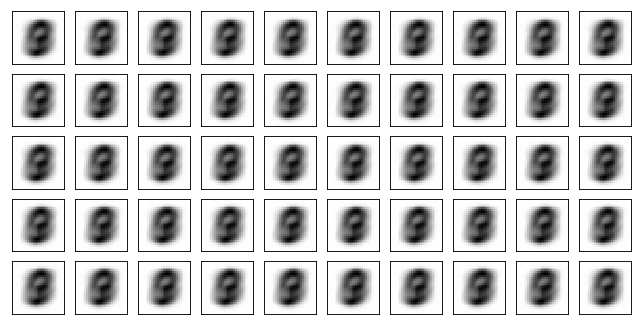

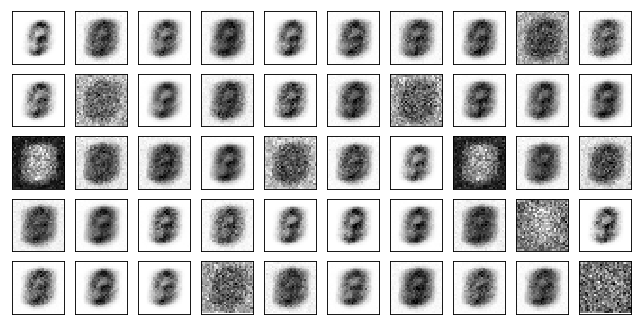

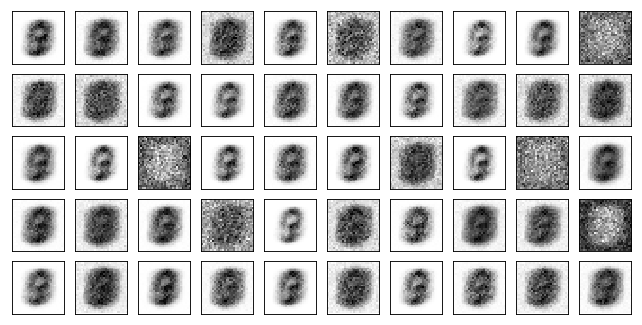

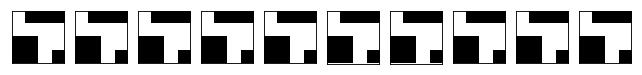

Test losses: 
Adam Discr+bn+dp: 1.34839857 / 3.37948275 / 0.00874370 

Train Epoch: 2 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:0.9244 D:0.0013
Train Epoch: 2 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:0.9491 D:0.0021
Train Epoch: 2 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:0.9992 D:0.0005
Train Epoch: 2 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.0023 D:0.0003
Train Epoch: 2 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.0014 D:0.0004
Train Epoch: 2 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:0.9906 D:0.0005
Model Adam Discr+bn+dp:


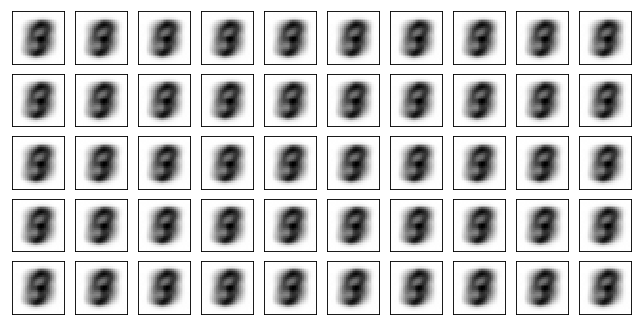

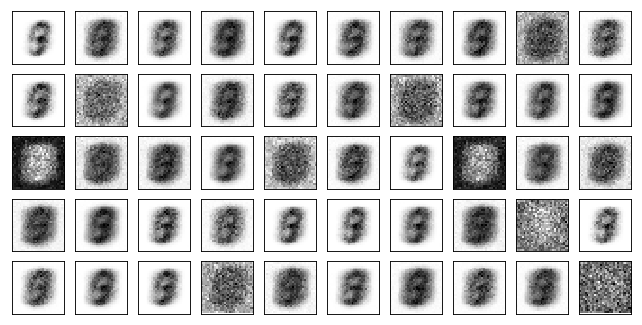

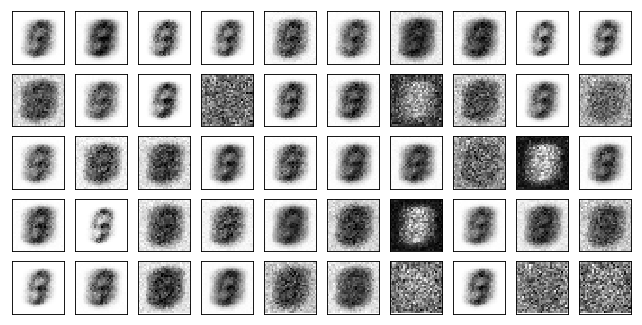

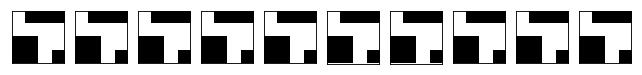

Test losses: 
Adam Discr+bn+dp: 1.34774446 / 3.85872436 / 0.00207403 

Train Epoch: 3 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:0.9891 D:0.0005
Train Epoch: 3 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.1130 D:0.0002
Train Epoch: 3 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.0963 D:0.0002
Train Epoch: 3 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.0889 D:0.0002
Train Epoch: 3 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.1177 D:0.0001
Train Epoch: 3 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.1456 D:0.0001
Model Adam Discr+bn+dp:


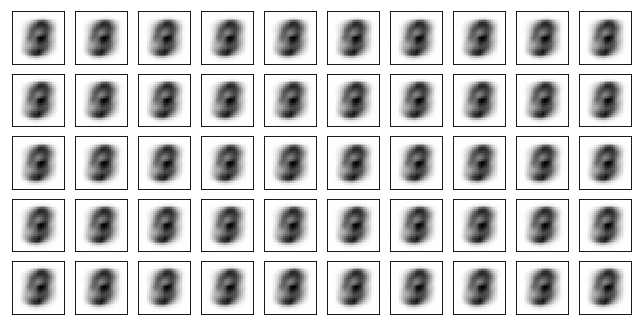

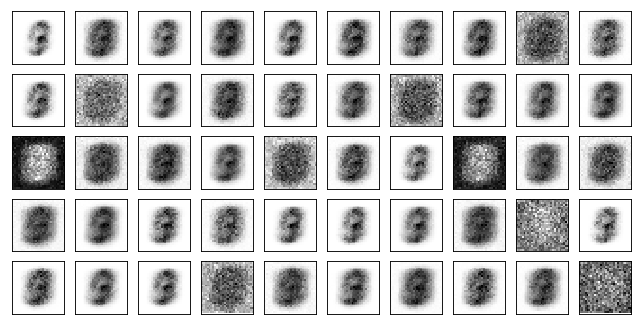

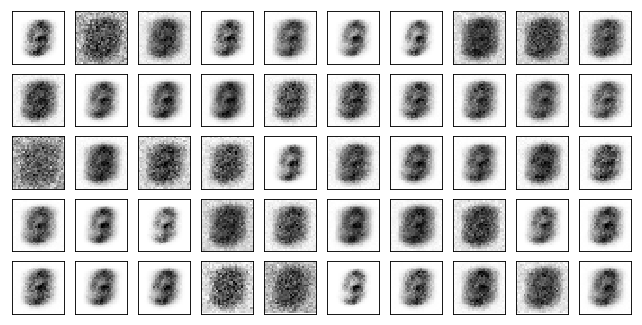

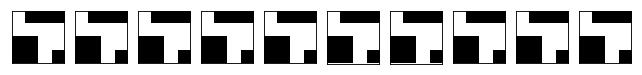

Test losses: 
Adam Discr+bn+dp: 1.34842718 / 4.51377296 / 0.00094697 

Train Epoch: 4 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.1547 D:0.0001
Train Epoch: 4 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.0848 D:0.0002
Train Epoch: 4 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.1658 D:0.0001
Train Epoch: 4 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.1568 D:0.0001
Train Epoch: 4 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.2124 D:0.0001
Train Epoch: 4 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.2373 D:0.0001
Model Adam Discr+bn+dp:


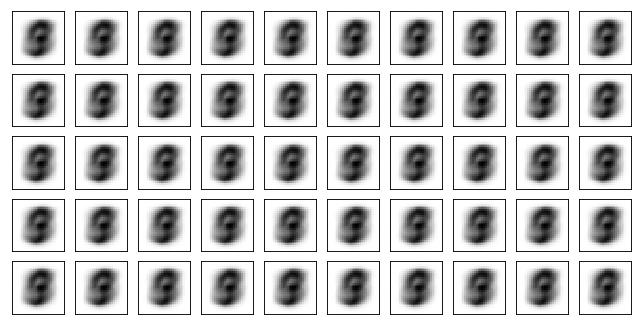

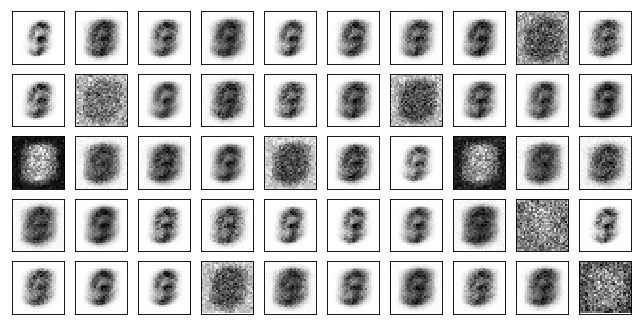

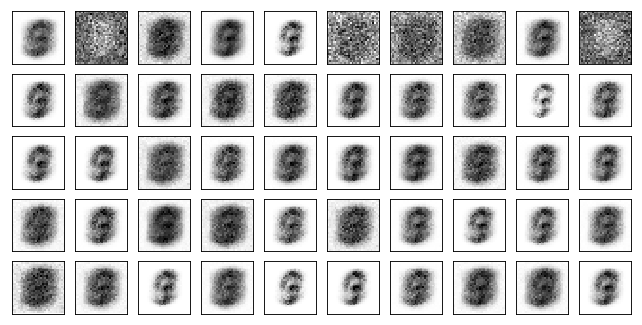

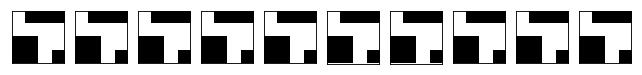

Test losses: 
Adam Discr+bn+dp: 1.34752071 / 4.93585014 / 0.00036867 

Train Epoch: 5 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.2104 D:0.0001
Train Epoch: 5 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.2211 D:0.0005
Train Epoch: 5 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.2393 D:0.0000
Train Epoch: 5 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.2662 D:0.0000
Train Epoch: 5 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.2234 D:0.0001
Train Epoch: 5 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.3149 D:0.0000
Model Adam Discr+bn+dp:


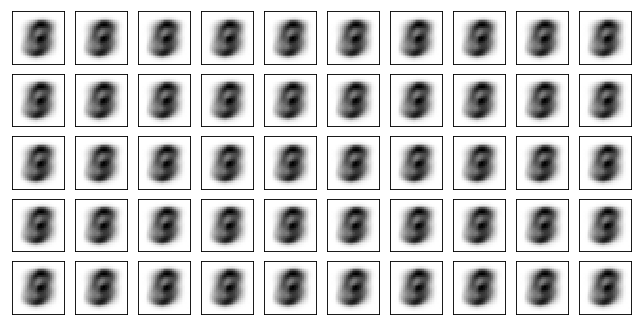

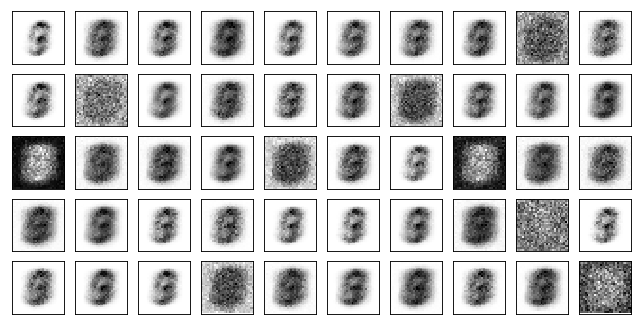

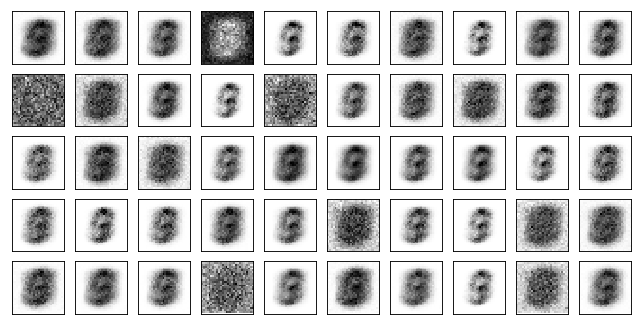

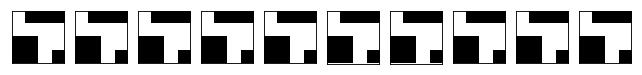

Test losses: 
Adam Discr+bn+dp: 1.34710968 / 5.39572811 / 0.00016503 

Train Epoch: 6 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.3678 D:0.0000
Train Epoch: 6 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.3108 D:0.0001
Train Epoch: 6 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.3128 D:0.0000
Train Epoch: 6 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.3711 D:0.0000
Train Epoch: 6 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.2118 D:0.0001
Train Epoch: 6 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.3348 D:0.0000
Model Adam Discr+bn+dp:


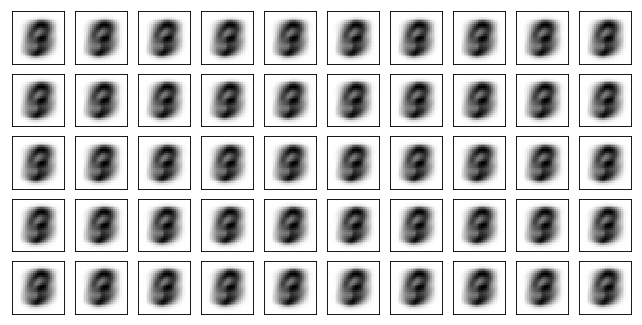

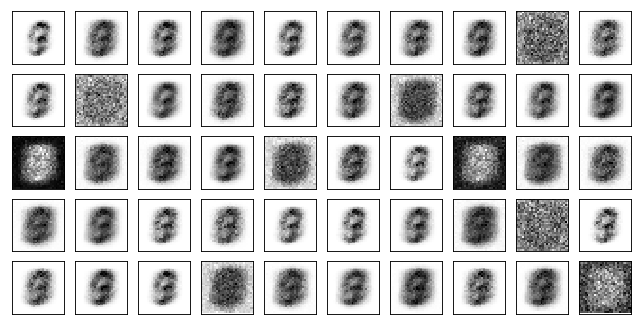

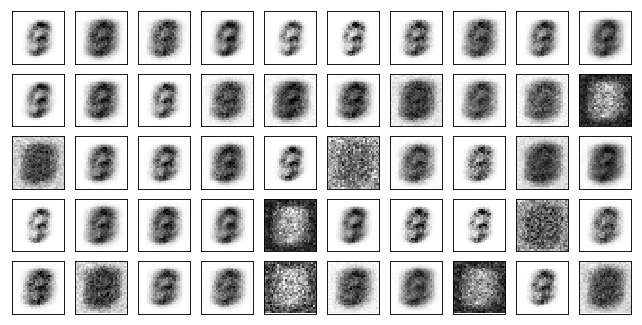

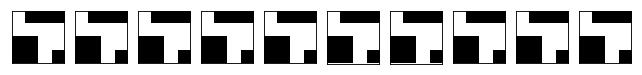

Test losses: 
Adam Discr+bn+dp: 1.34861231 / 5.48577261 / 0.00030524 

Train Epoch: 7 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.3083 D:0.0000
Train Epoch: 7 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.3789 D:0.0000
Train Epoch: 7 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.3995 D:0.0000
Train Epoch: 7 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.4552 D:0.0000
Train Epoch: 7 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:0.8932 D:0.0015
Train Epoch: 7 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:0.9728 D:0.0016
Model Adam Discr+bn+dp:


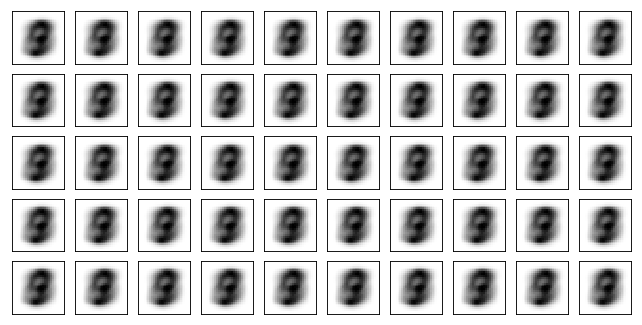

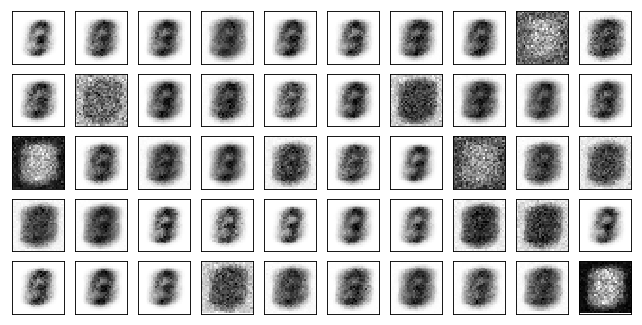

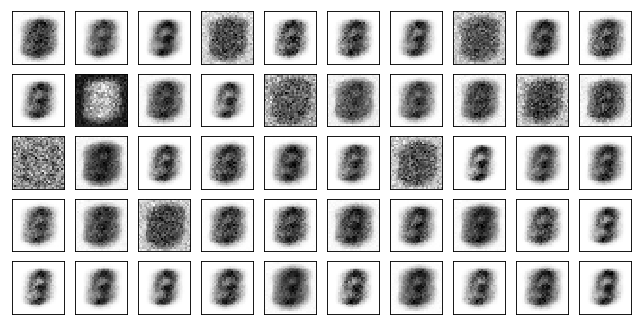

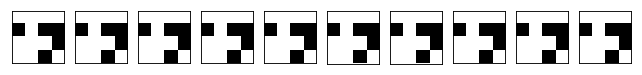

Test losses: 
Adam Discr+bn+dp: 1.34711981 / 3.56761265 / 0.01835740 

Train Epoch: 8 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:0.9154 D:0.0358
Train Epoch: 8 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:0.9856 D:0.0008
Train Epoch: 8 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.0072 D:0.0003
Train Epoch: 8 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.1036 D:0.0003
Train Epoch: 8 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.1145 D:0.0002
Train Epoch: 8 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.1937 D:0.0002
Model Adam Discr+bn+dp:


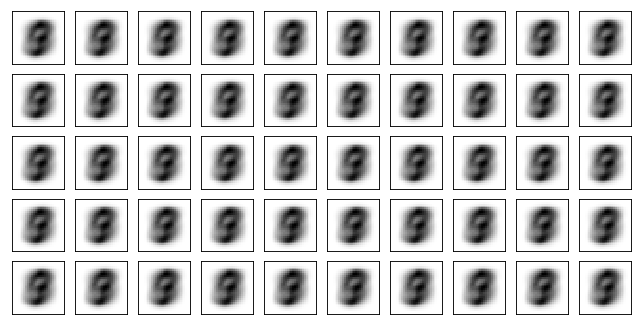

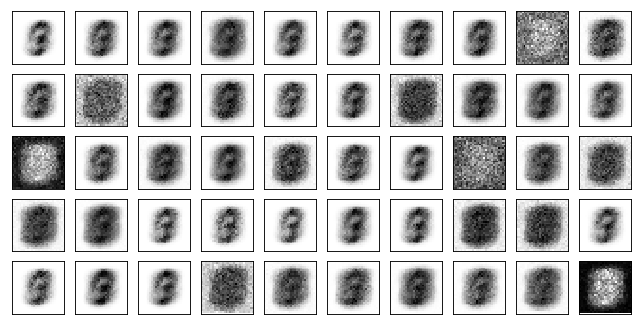

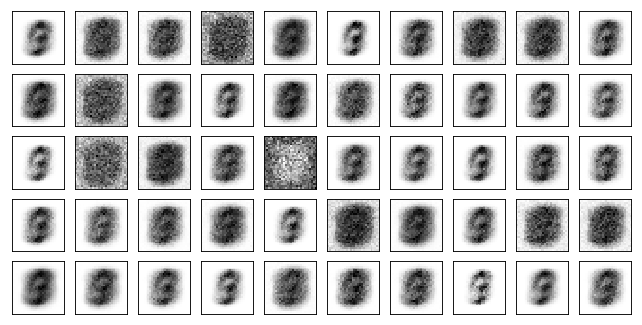

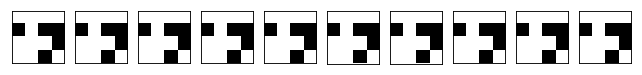

Test losses: 
Adam Discr+bn+dp: 1.34714842 / 4.55171776 / 0.00161369 

Train Epoch: 9 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.1440 D:0.0002
Train Epoch: 9 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.1443 D:0.0002
Train Epoch: 9 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.1474 D:0.0002
Train Epoch: 9 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.1266 D:0.0002
Train Epoch: 9 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.1319 D:0.0003
Train Epoch: 9 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.1385 D:0.0002
Model Adam Discr+bn+dp:


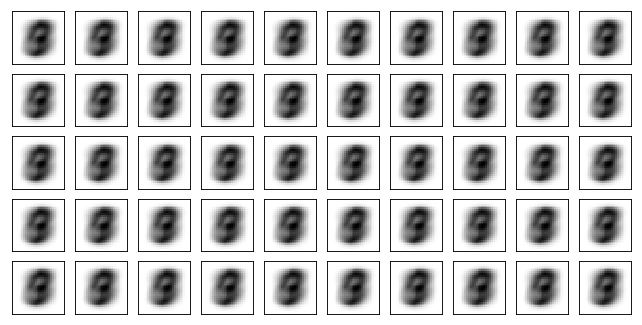

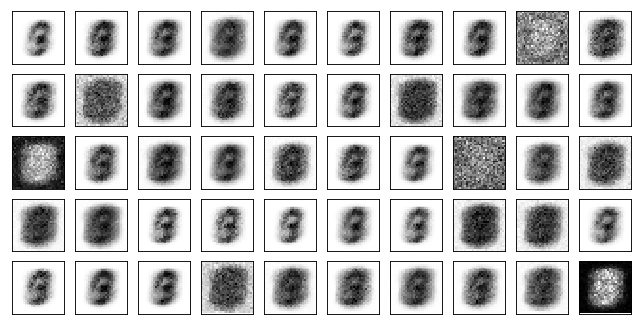

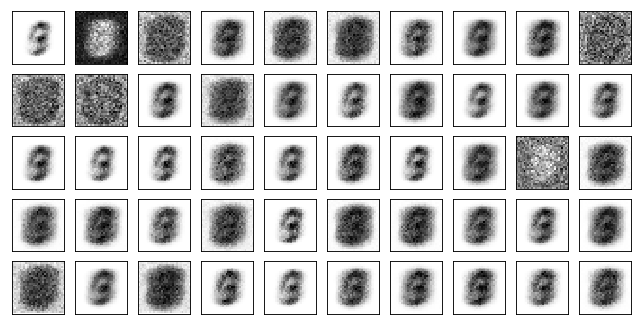

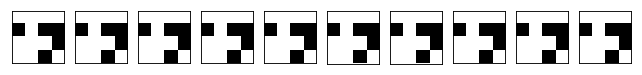

Test losses: 
Adam Discr+bn+dp: 1.34712756 / 4.64750195 / 0.00060724 

Train Epoch: 10 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.1677 D:0.0002
Train Epoch: 10 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.2133 D:0.0001
Train Epoch: 10 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.1738 D:0.0001
Train Epoch: 10 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.2520 D:0.0000
Train Epoch: 10 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.2699 D:0.0122
Train Epoch: 10 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.3058 D:0.0001
Model Adam Discr+bn+dp:


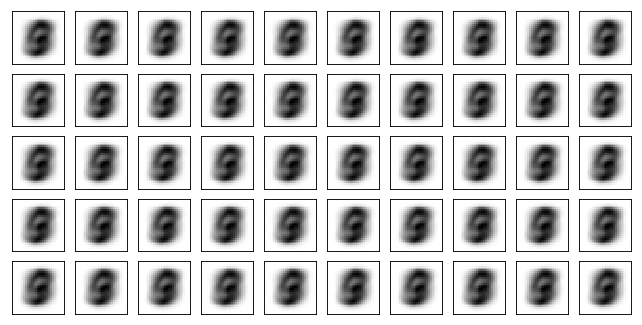

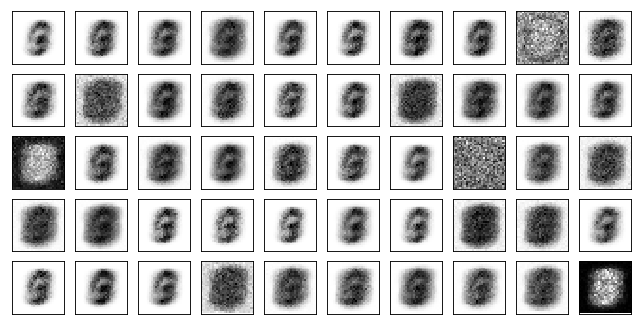

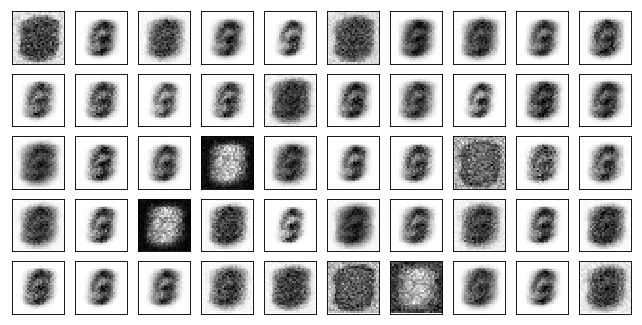

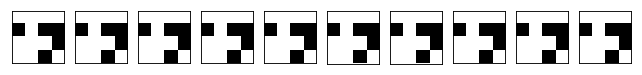

Test losses: 
Adam Discr+bn+dp: 1.34731519 / 5.11293411 / 0.00016389 

Train Epoch: 11 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.2756 D:0.0000
Train Epoch: 11 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.3284 D:0.0000
Train Epoch: 11 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.2964 D:0.0000
Train Epoch: 11 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.2674 D:0.0001
Train Epoch: 11 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.2935 D:0.0000
Train Epoch: 11 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.2805 D:0.0000
Model Adam Discr+bn+dp:


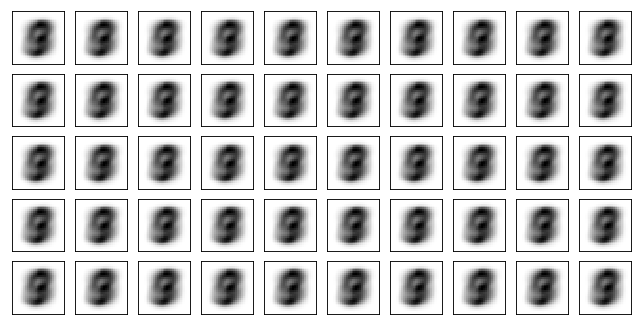

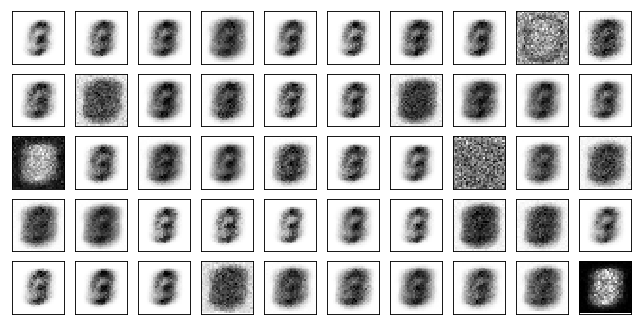

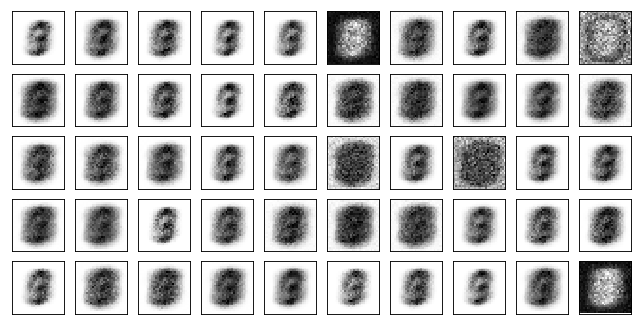

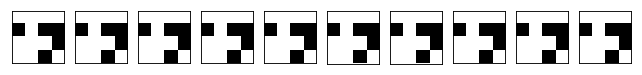

Test losses: 
Adam Discr+bn+dp: 1.34634602 / 5.20134544 / 0.00020059 

Train Epoch: 12 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.2570 D:0.0000
Train Epoch: 12 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.3869 D:0.0000
Train Epoch: 12 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.3575 D:0.0000
Train Epoch: 12 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.3003 D:0.0001
Train Epoch: 12 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.2308 D:0.0001
Train Epoch: 12 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.3903 D:0.0000
Model Adam Discr+bn+dp:


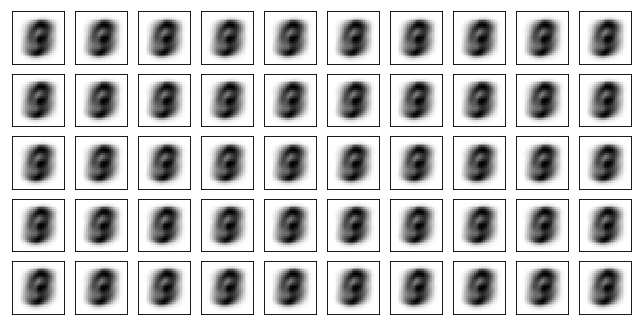

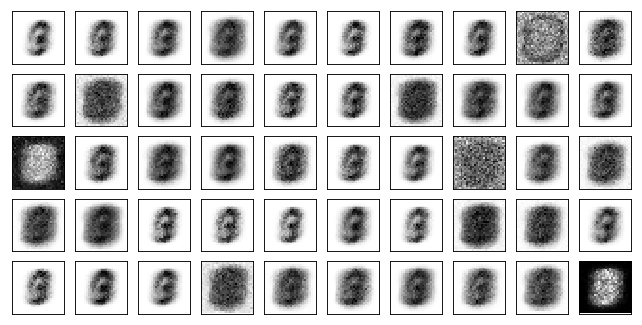

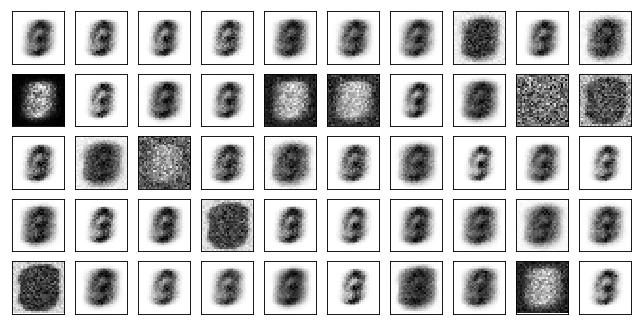

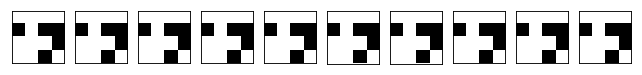

Test losses: 
Adam Discr+bn+dp: 1.34672403 / 5.60939264 / 0.00004243 

Train Epoch: 13 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.3515 D:0.0000
Train Epoch: 13 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.4071 D:0.0000
Train Epoch: 13 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.4077 D:0.0000
Train Epoch: 13 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.4425 D:0.0000
Train Epoch: 13 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.4886 D:0.0000
Train Epoch: 13 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.4400 D:0.0000
Model Adam Discr+bn+dp:


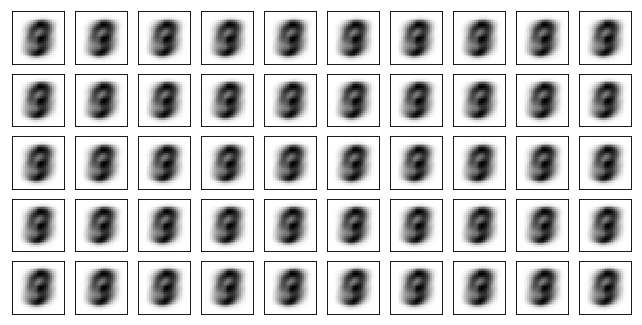

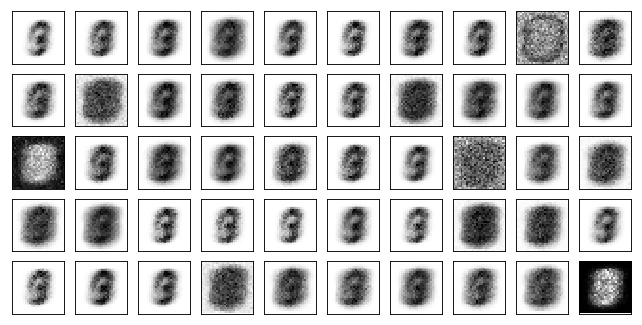

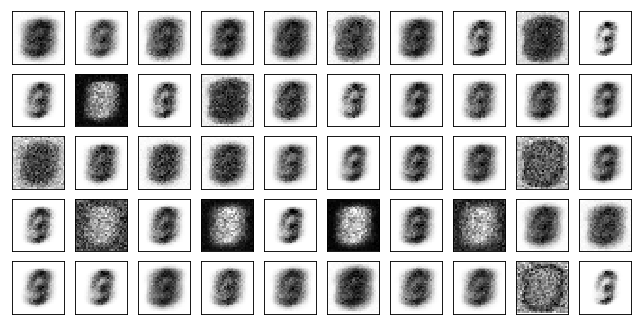

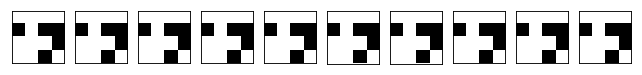

Test losses: 
Adam Discr+bn+dp: 1.34714627 / 6.07447433 / 0.00006309 

Train Epoch: 14 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.4213 D:0.0000
Train Epoch: 14 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.3991 D:0.0000
Train Epoch: 14 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.4175 D:0.0000
Train Epoch: 14 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.5109 D:0.0000
Train Epoch: 14 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.4356 D:0.0000
Train Epoch: 14 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.4923 D:0.0000
Model Adam Discr+bn+dp:


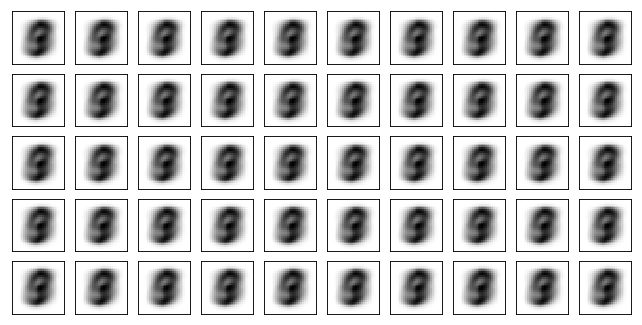

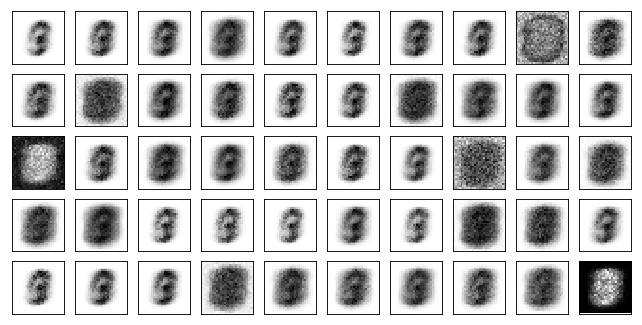

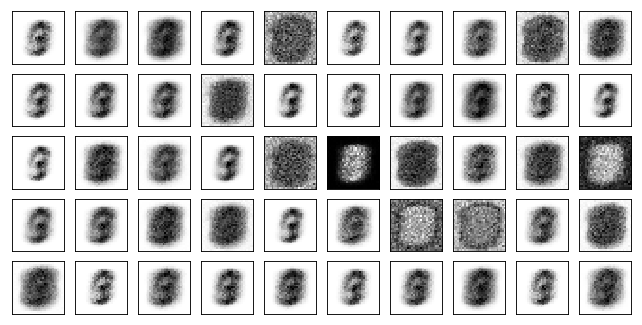

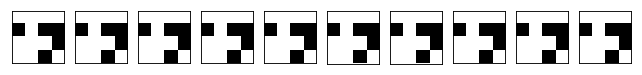

Test losses: 
Adam Discr+bn+dp: 1.34625173 / 6.30529785 / 0.00003367 

Train Epoch: 15 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.4647 D:0.0000
Train Epoch: 15 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.3980 D:0.0000
Train Epoch: 15 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.4833 D:0.0000
Train Epoch: 15 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.1123 D:0.0020
Train Epoch: 15 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.2547 D:0.0004
Train Epoch: 15 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.2617 D:0.0007
Model Adam Discr+bn+dp:


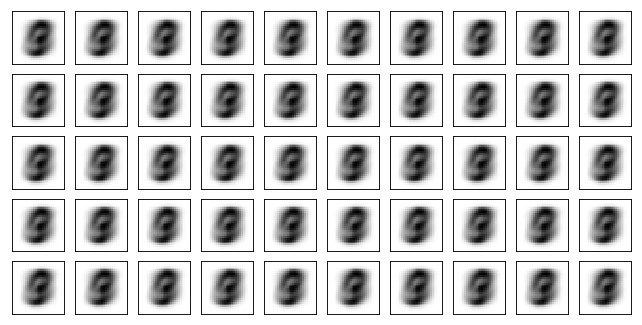

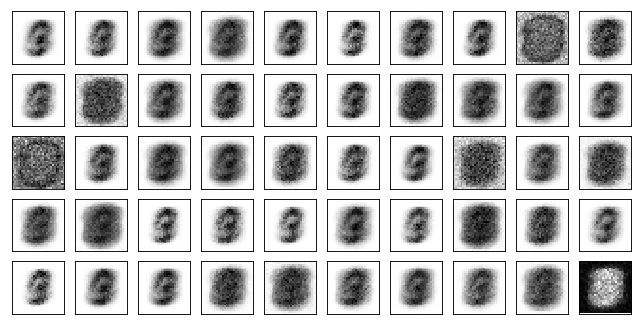

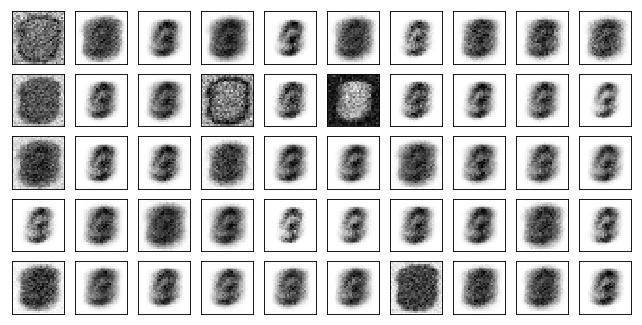

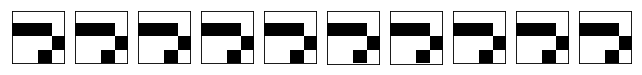

Test losses: 
Adam Discr+bn+dp: 1.34758770 / 4.93797445 / 0.00231747 

Train Epoch: 16 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.2107 D:0.0001
Train Epoch: 16 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.2136 D:0.0005
Train Epoch: 16 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.3229 D:0.0000
Train Epoch: 16 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.2677 D:0.0001
Train Epoch: 16 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.3150 D:0.0001
Train Epoch: 16 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.3294 D:0.0000
Model Adam Discr+bn+dp:


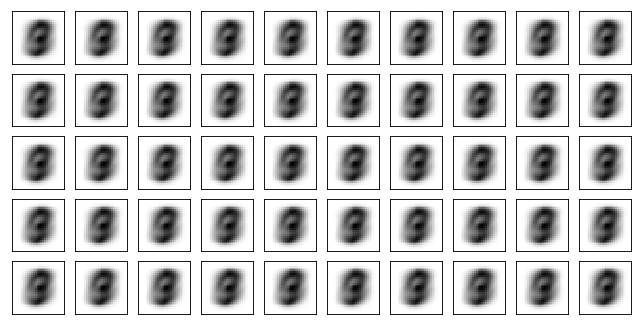

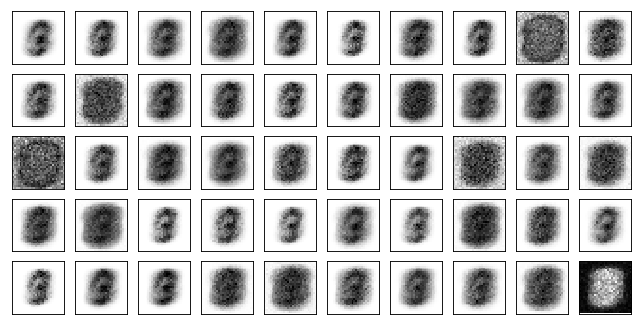

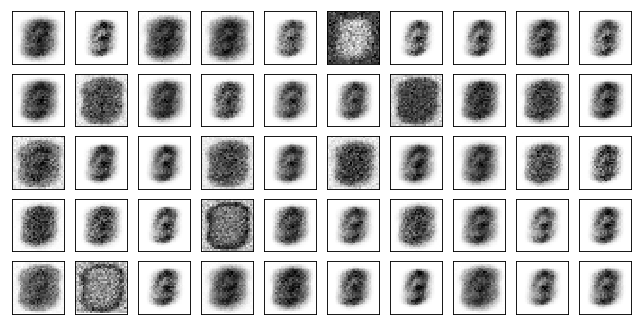

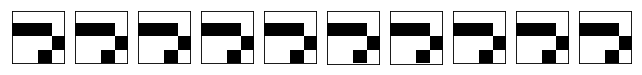

Test losses: 
Adam Discr+bn+dp: 1.34647000 / 5.42975807 / 0.00012782 

Train Epoch: 17 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.3691 D:0.0001
Train Epoch: 17 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.3185 D:0.0001
Train Epoch: 17 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.2773 D:0.0001
Train Epoch: 17 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.3880 D:0.0000
Train Epoch: 17 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.3238 D:0.0001
Train Epoch: 17 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.4270 D:0.0000
Model Adam Discr+bn+dp:


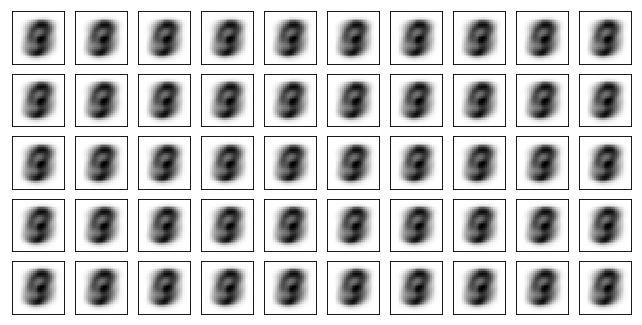

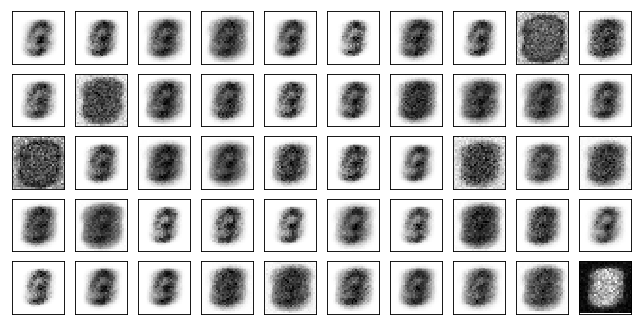

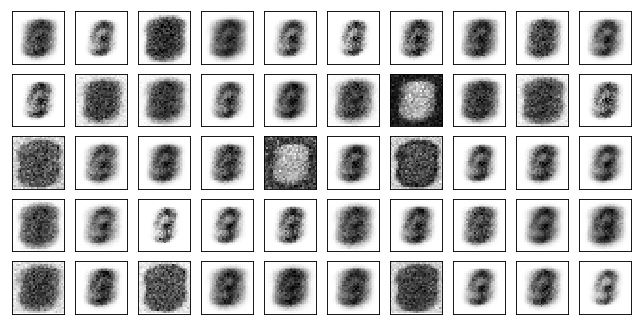

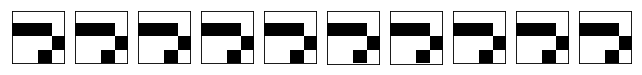

Test losses: 
Adam Discr+bn+dp: 1.34635162 / 5.93164349 / 0.00058091 

Train Epoch: 18 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.4383 D:0.0000
Train Epoch: 18 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.3786 D:0.0000
Train Epoch: 18 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.4249 D:0.0000
Train Epoch: 18 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.4356 D:0.0000
Train Epoch: 18 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.4837 D:0.0000
Train Epoch: 18 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.3894 D:0.0000
Model Adam Discr+bn+dp:


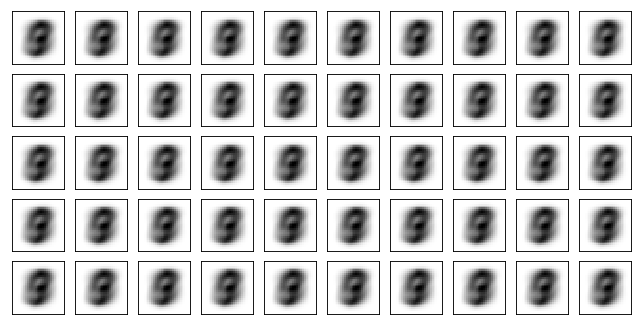

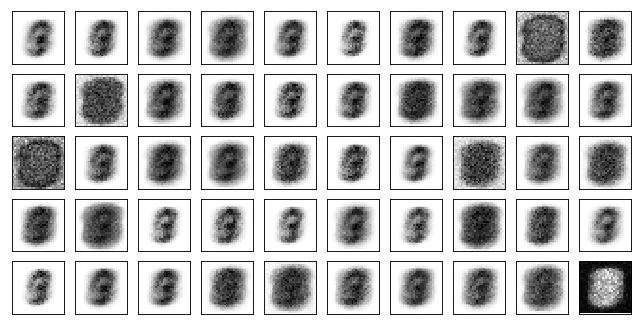

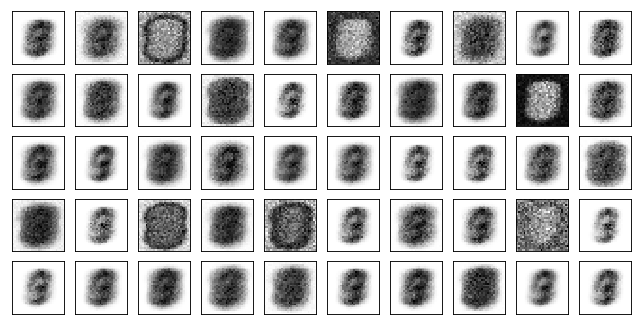

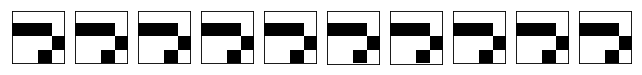

Test losses: 
Adam Discr+bn+dp: 1.34652865 / 5.84142351 / 0.00004927 

Train Epoch: 19 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.3930 D:0.0000
Train Epoch: 19 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.3703 D:0.0000
Train Epoch: 19 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.4753 D:0.0000
Train Epoch: 19 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.4920 D:0.0000
Train Epoch: 19 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.4792 D:0.0000
Train Epoch: 19 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.5026 D:0.0000
Model Adam Discr+bn+dp:


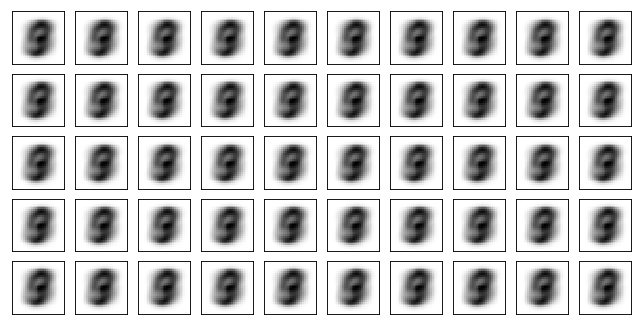

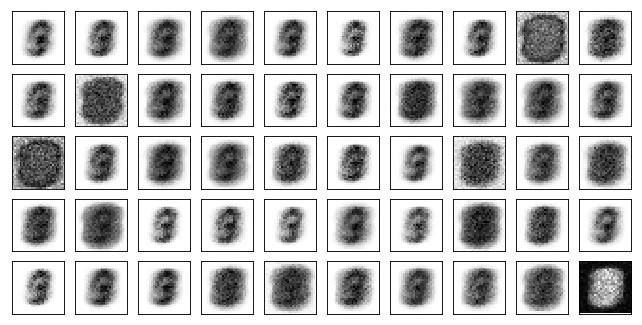

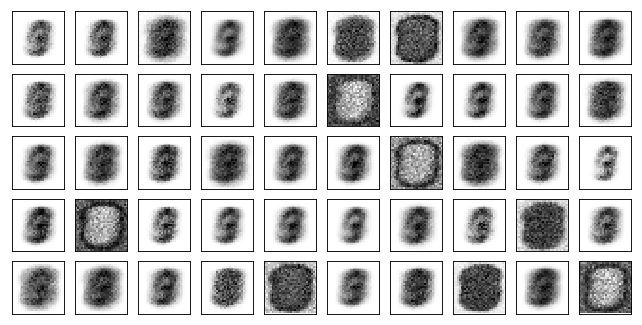

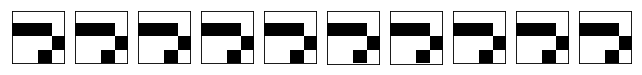

Test losses: 
Adam Discr+bn+dp: 1.34640503 / 6.28107786 / 0.00001787 

Train Epoch: 20 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.5124 D:0.0000
Train Epoch: 20 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.5148 D:0.0000
Train Epoch: 20 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.5116 D:0.0000
Train Epoch: 20 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.3219 D:0.0001
Train Epoch: 20 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.5353 D:0.0000
Train Epoch: 20 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.5299 D:0.0000
Model Adam Discr+bn+dp:


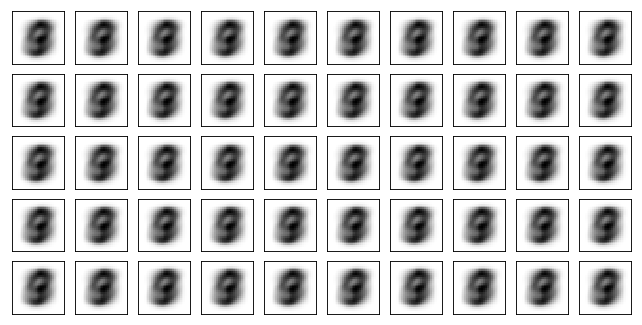

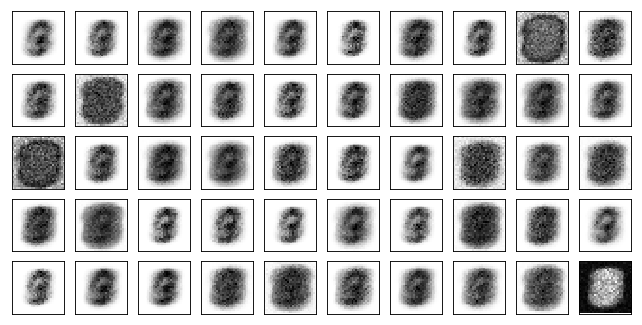

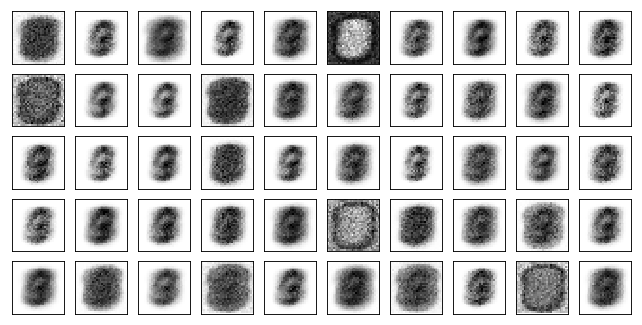

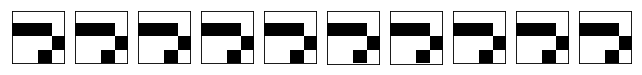

Test losses: 
Adam Discr+bn+dp: 1.34648943 / 6.53765488 / 0.00014670 

Train Epoch: 21 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.5563 D:0.0000
Train Epoch: 21 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.5547 D:0.0000
Train Epoch: 21 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.6024 D:0.0000
Train Epoch: 21 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.5780 D:0.0000
Train Epoch: 21 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.6282 D:0.0000
Train Epoch: 21 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.5014 D:0.0000
Model Adam Discr+bn+dp:


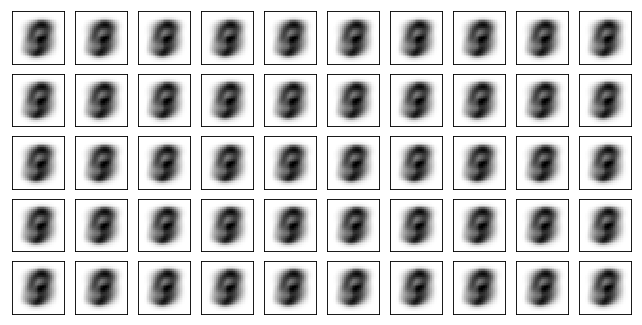

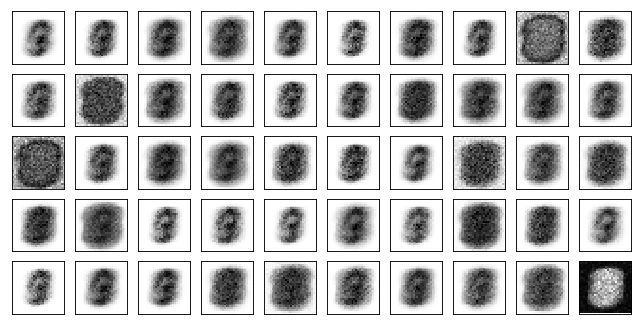

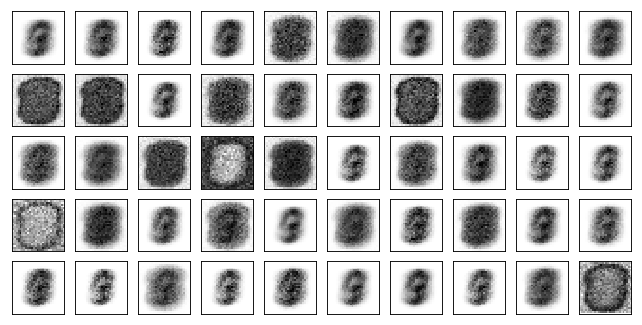

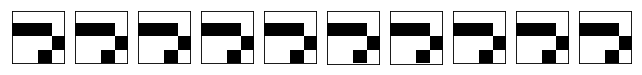

Test losses: 
Adam Discr+bn+dp: 1.34622812 / 6.21008778 / 0.00001033 

Train Epoch: 22 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.4791 D:0.0000
Train Epoch: 22 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.5572 D:0.0000
Train Epoch: 22 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.5190 D:0.0000
Train Epoch: 22 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.5878 D:0.0000
Train Epoch: 22 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.6772 D:0.0000
Train Epoch: 22 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.6858 D:0.0000
Model Adam Discr+bn+dp:


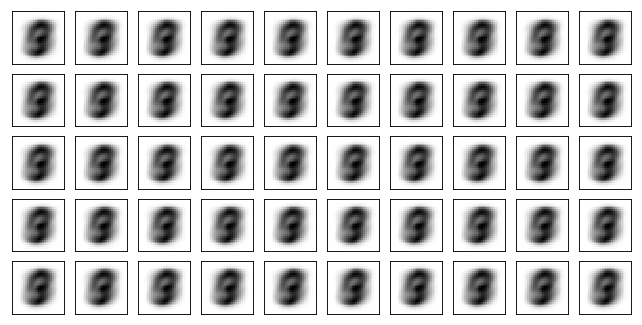

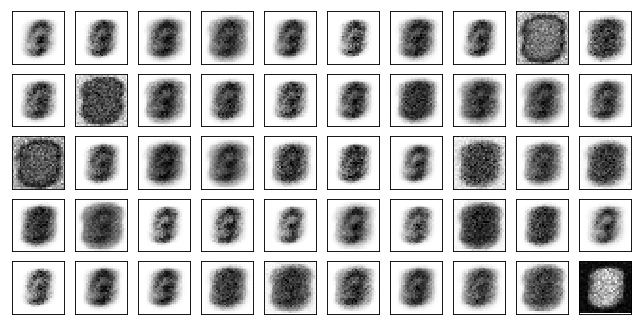

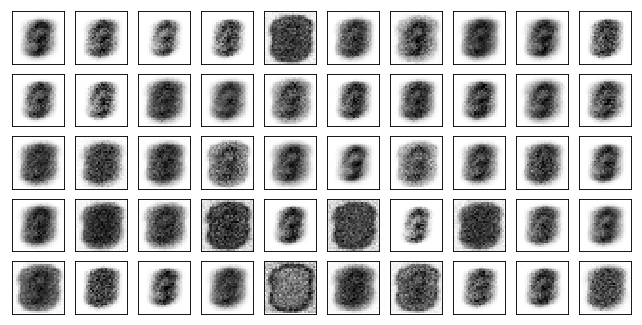

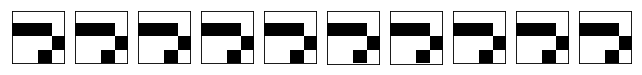

Test losses: 
Adam Discr+bn+dp: 1.34629595 / 7.22611427 / 0.00005943 

Train Epoch: 23 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.6676 D:0.0000
Train Epoch: 23 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.5661 D:0.0000
Train Epoch: 23 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.2926 D:0.0001
Train Epoch: 23 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.5670 D:0.0000
Train Epoch: 23 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.5776 D:0.0000
Train Epoch: 23 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.5425 D:0.0000
Model Adam Discr+bn+dp:


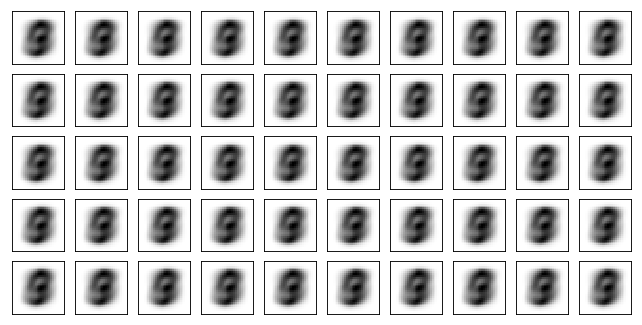

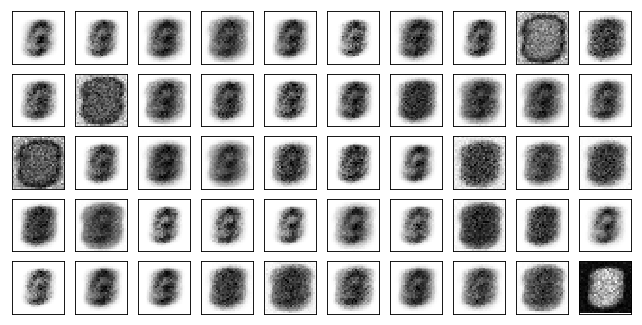

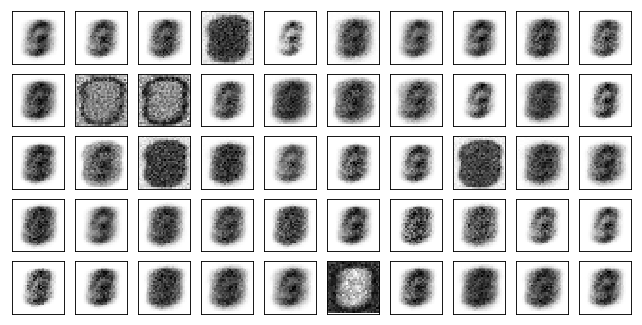

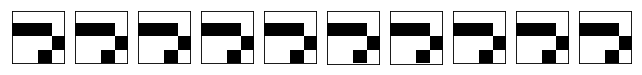

Test losses: 
Adam Discr+bn+dp: 1.34622741 / 6.62392378 / 0.00000569 

Train Epoch: 24 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.5588 D:0.0000
Train Epoch: 24 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.6733 D:0.0000
Train Epoch: 24 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.2023 D:0.0001
Train Epoch: 24 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.4816 D:0.0000
Train Epoch: 24 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.4982 D:0.0000
Train Epoch: 24 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.5751 D:0.0000
Model Adam Discr+bn+dp:


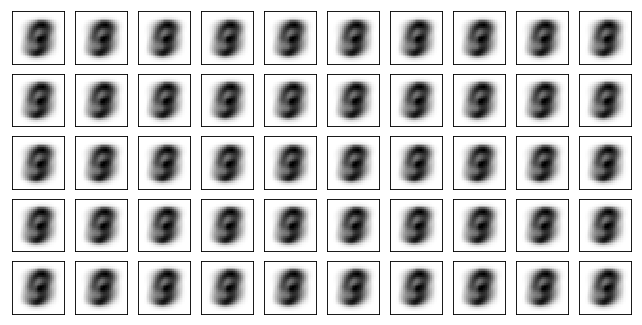

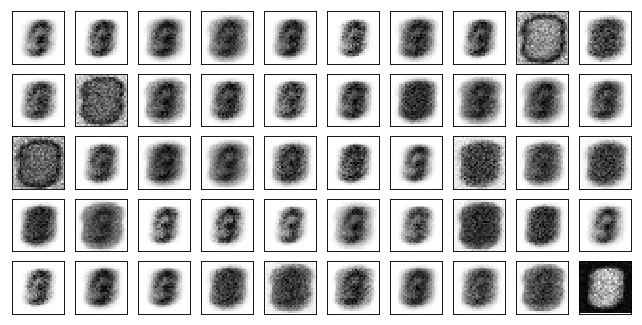

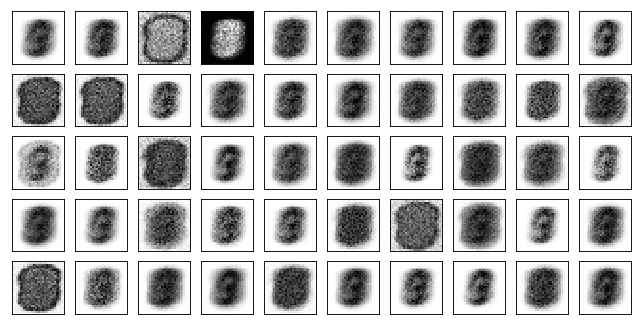

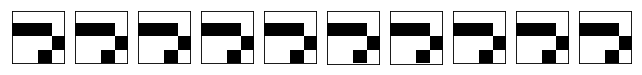

Test losses: 
Adam Discr+bn+dp: 1.34615064 / 6.80963564 / 0.00000312 

Train Epoch: 25 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.6257 D:0.0000
Train Epoch: 25 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.6818 D:0.0000
Train Epoch: 25 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.5192 D:0.0000
Train Epoch: 25 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.5956 D:0.0000
Train Epoch: 25 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.6827 D:0.0000
Train Epoch: 25 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.6918 D:0.0000
Model Adam Discr+bn+dp:


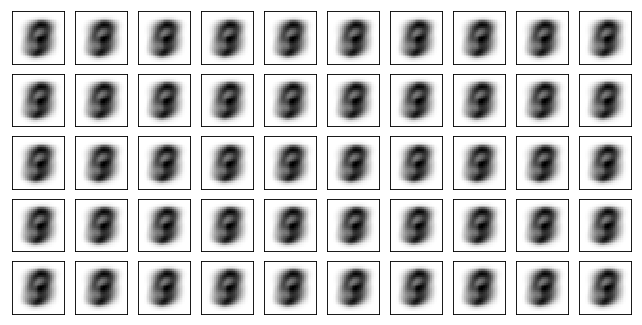

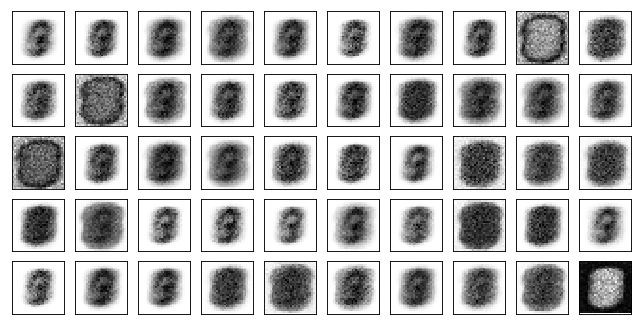

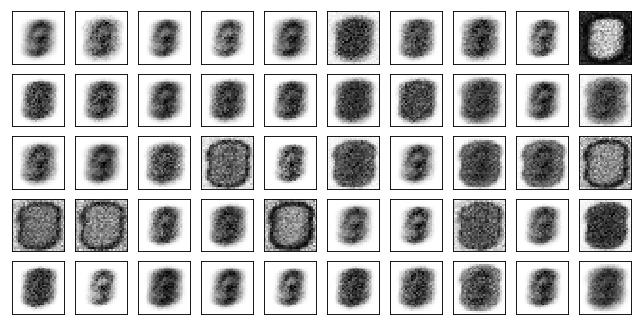

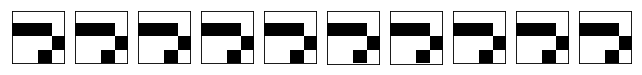

Test losses: 
Adam Discr+bn+dp: 1.34628510 / 7.19804144 / 0.00000161 

Train Epoch: 26 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.6851 D:0.0000
Train Epoch: 26 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.7180 D:0.0000
Train Epoch: 26 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.2402 D:0.0003
Train Epoch: 26 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.3170 D:0.0001
Train Epoch: 26 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.3288 D:0.0138
Train Epoch: 26 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.4807 D:0.0000
Model Adam Discr+bn+dp:


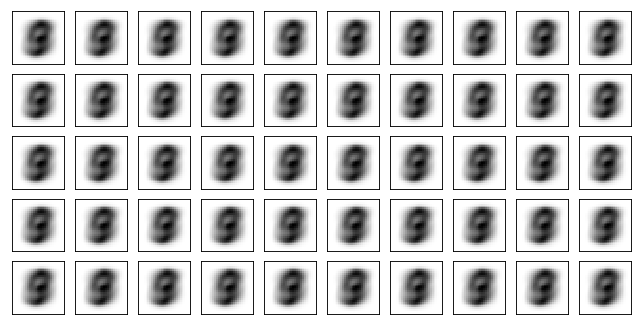

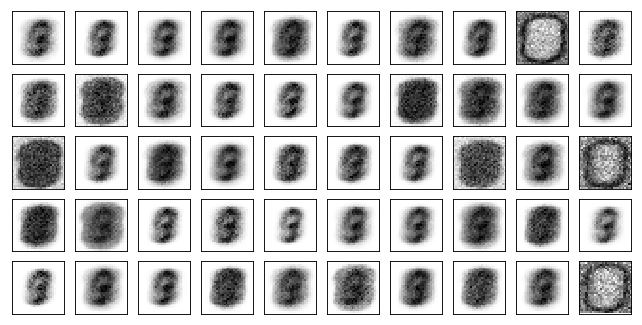

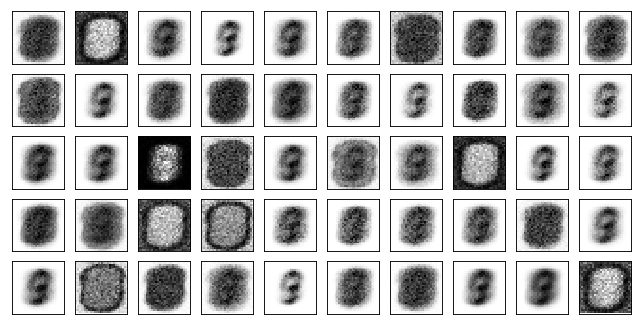

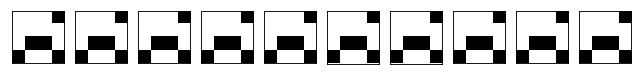

Test losses: 
Adam Discr+bn+dp: 1.34628665 / 6.26915836 / 0.00235475 

Train Epoch: 27 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.4748 D:0.0000
Train Epoch: 27 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.3651 D:0.0024
Train Epoch: 27 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.4494 D:0.0000
Train Epoch: 27 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.4095 D:0.0001
Train Epoch: 27 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.4399 D:0.0000
Train Epoch: 27 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.4276 D:0.0000
Model Adam Discr+bn+dp:


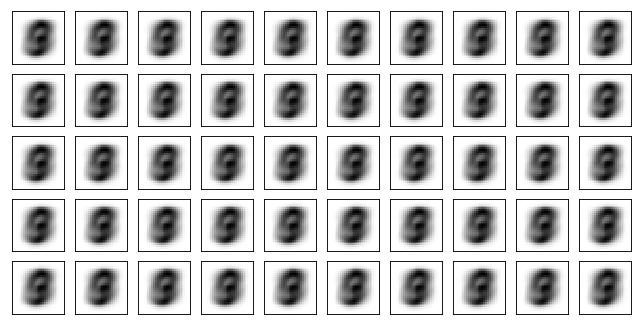

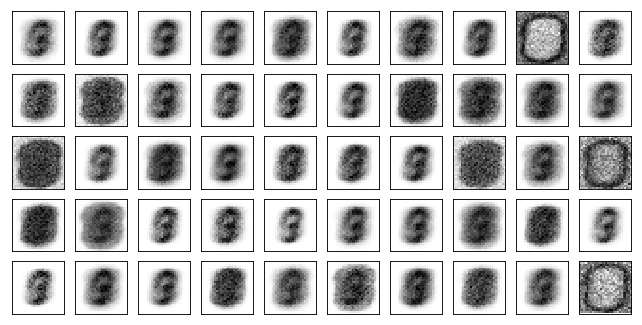

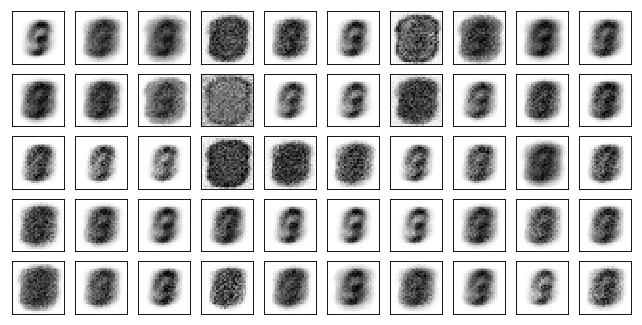

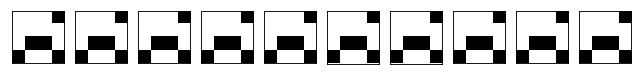

Test losses: 
Adam Discr+bn+dp: 1.34642243 / 6.06506777 / 0.00105686 

Train Epoch: 28 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.4579 D:0.0000
Train Epoch: 28 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.4282 D:0.0004
Train Epoch: 28 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.4663 D:0.0000
Train Epoch: 28 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.4435 D:0.0000
Train Epoch: 28 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.4637 D:0.0001
Train Epoch: 28 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.5540 D:0.0000
Model Adam Discr+bn+dp:


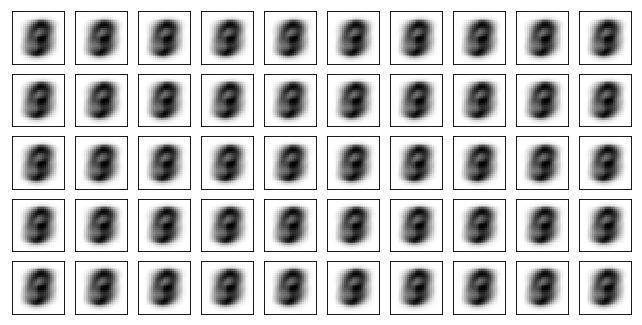

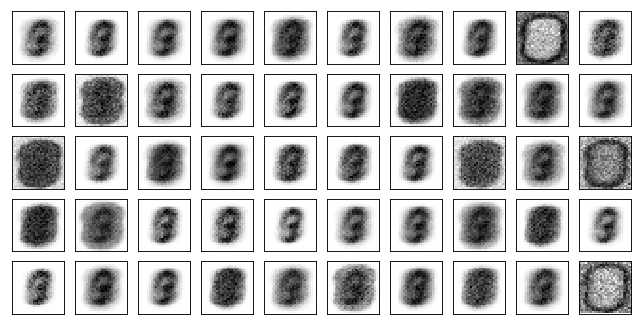

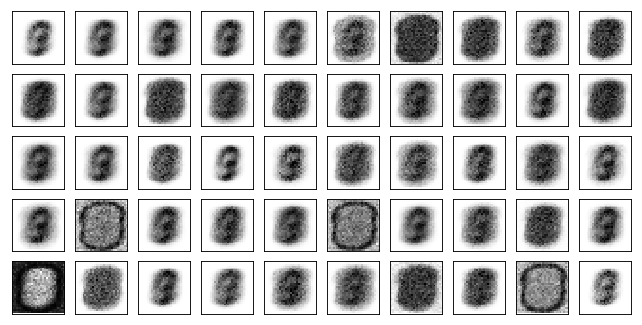

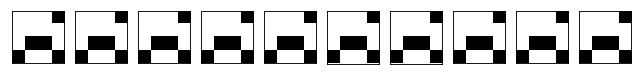

Test losses: 
Adam Discr+bn+dp: 1.34758270 / 6.41399002 / 0.00006348 

Train Epoch: 29 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.5586 D:0.0000
Train Epoch: 29 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.5087 D:0.0000
Train Epoch: 29 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.5613 D:0.0000
Train Epoch: 29 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.5636 D:0.0000
Train Epoch: 29 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.5711 D:0.0000
Train Epoch: 29 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.6683 D:0.0000
Model Adam Discr+bn+dp:


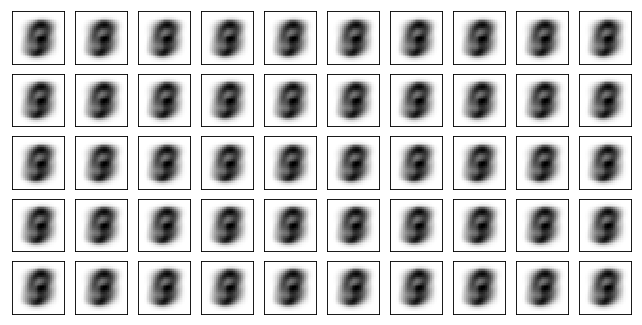

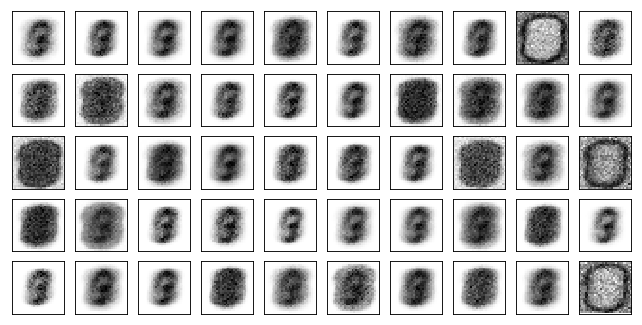

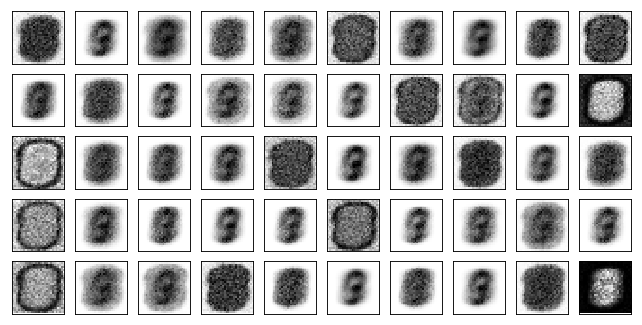

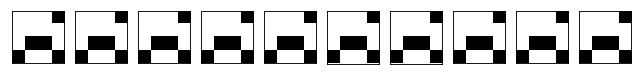

Test losses: 
Adam Discr+bn+dp: 1.34622622 / 6.97000360 / 0.00007229 

Train Epoch: 30 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.6285 D:0.0000
Train Epoch: 30 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.6844 D:0.0000
Train Epoch: 30 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.5350 D:0.0000
Train Epoch: 30 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.6480 D:0.0000
Train Epoch: 30 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.5637 D:0.0000
Train Epoch: 30 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.6635 D:0.0000
Model Adam Discr+bn+dp:


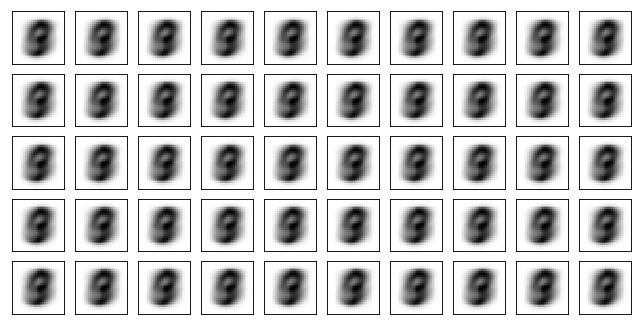

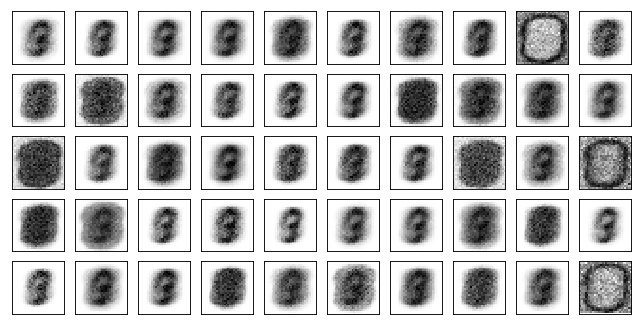

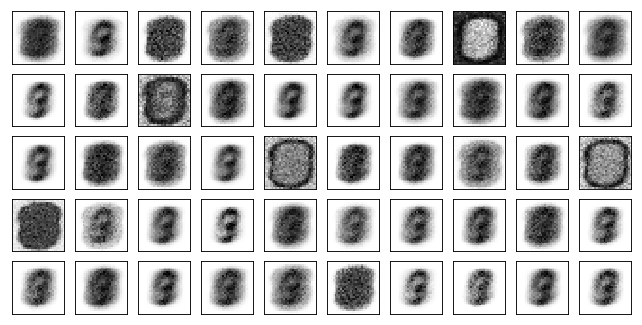

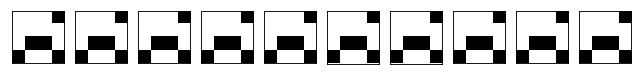

Test losses: 
Adam Discr+bn+dp: 1.34618545 / 7.16597414 / 0.00000388 

Train Epoch: 31 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.6361 D:0.0000
Train Epoch: 31 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.6835 D:0.0000
Train Epoch: 31 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.6905 D:0.0000
Train Epoch: 31 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.6064 D:0.0000
Train Epoch: 31 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.6665 D:0.0000
Train Epoch: 31 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.7267 D:0.0000
Model Adam Discr+bn+dp:


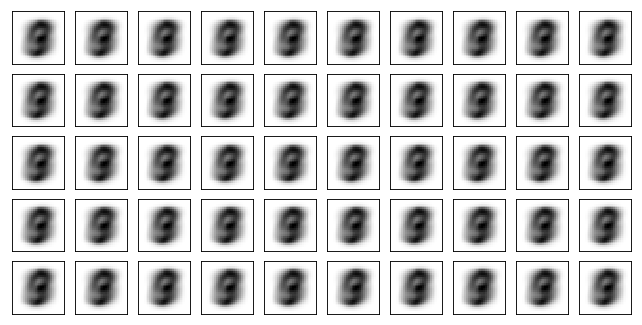

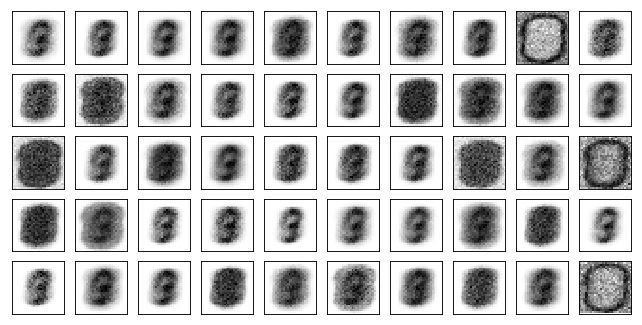

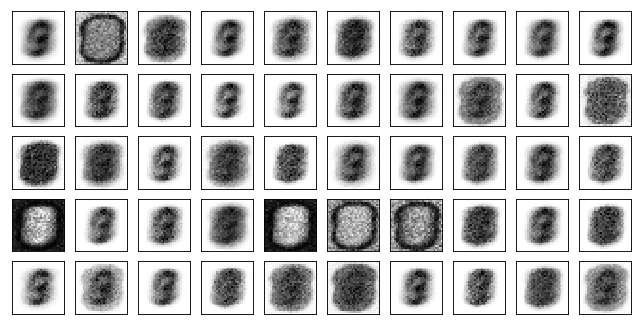

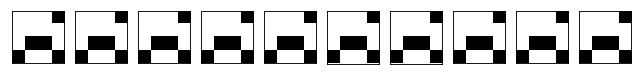

Test losses: 
Adam Discr+bn+dp: 1.34609044 / 7.42659712 / 0.00026400 

Train Epoch: 32 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.7091 D:0.0000
Train Epoch: 32 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.7141 D:0.0000
Train Epoch: 32 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.6956 D:0.0000
Train Epoch: 32 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.7320 D:0.0000
Train Epoch: 32 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.6768 D:0.0000
Train Epoch: 32 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.6946 D:0.0000
Model Adam Discr+bn+dp:


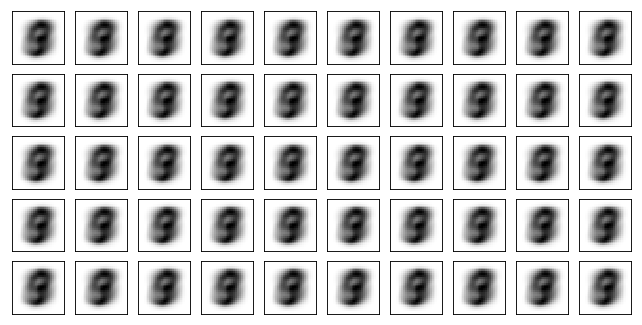

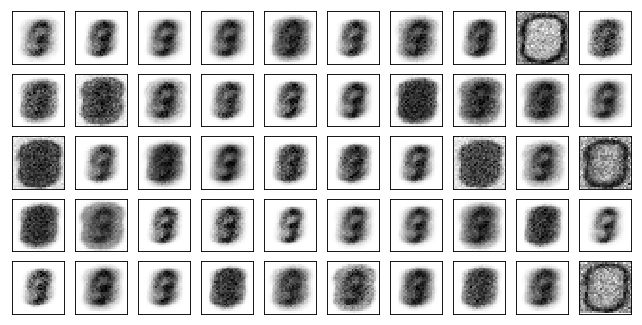

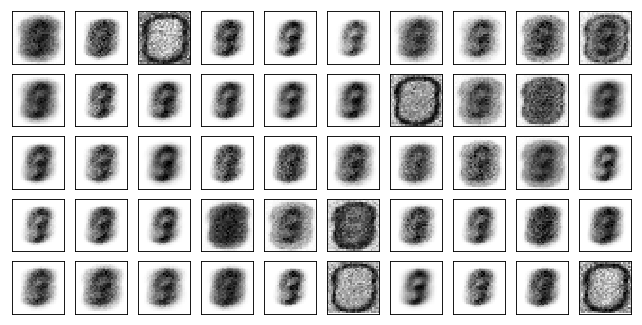

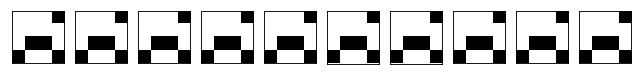

Test losses: 
Adam Discr+bn+dp: 1.34616148 / 7.32160711 / 0.00000870 

Train Epoch: 33 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.7003 D:0.0000
Train Epoch: 33 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.6525 D:0.0000
Train Epoch: 33 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.7445 D:0.0000
Train Epoch: 33 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.3461 D:0.0001
Train Epoch: 33 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.6579 D:0.0000
Train Epoch: 33 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.7512 D:0.0000
Model Adam Discr+bn+dp:


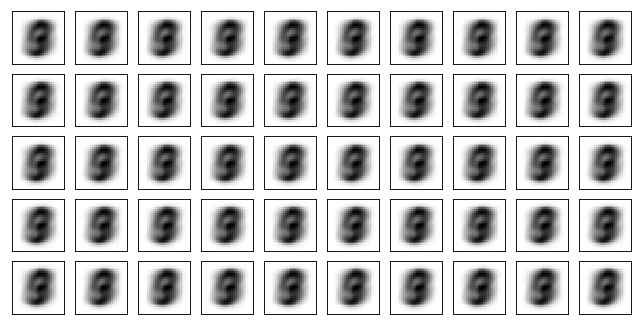

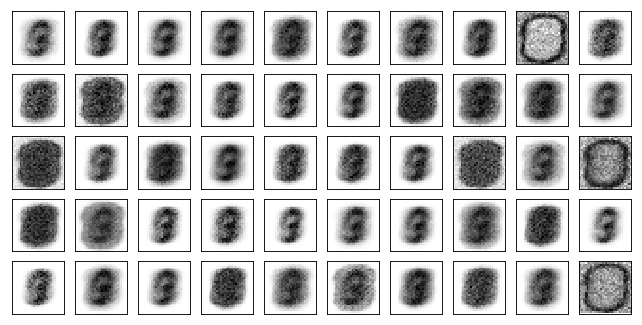

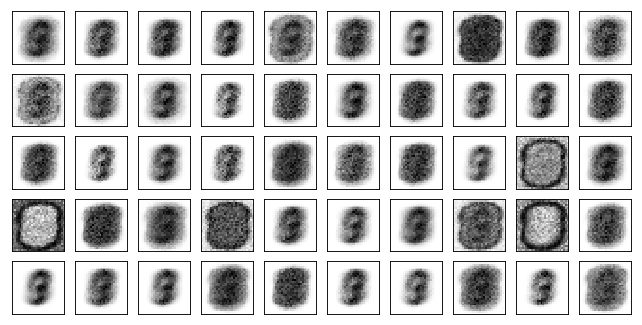

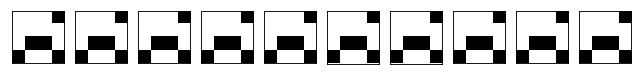

Test losses: 
Adam Discr+bn+dp: 1.34628856 / 7.48292303 / 0.00006125 

Train Epoch: 34 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.6944 D:0.0000
Train Epoch: 34 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.7737 D:0.0000
Train Epoch: 34 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.8325 D:0.0000
Train Epoch: 34 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.7792 D:0.0000
Train Epoch: 34 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.8265 D:0.0000
Train Epoch: 34 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.6194 D:0.0000
Model Adam Discr+bn+dp:


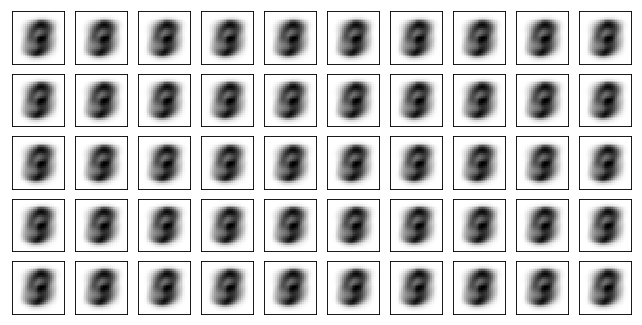

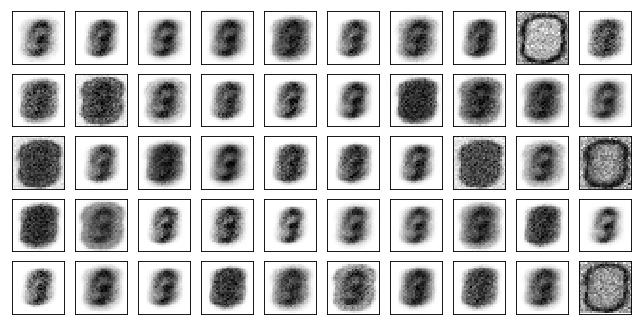

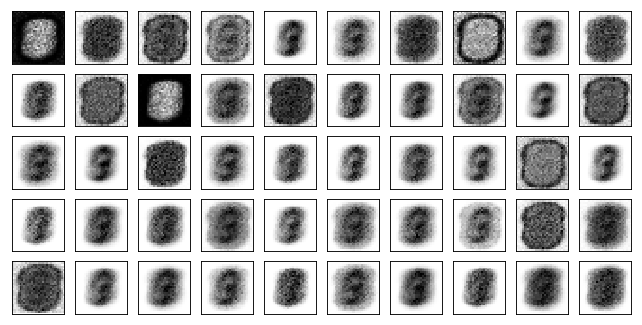

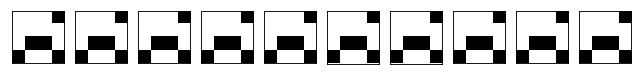

Test losses: 
Adam Discr+bn+dp: 1.34629095 / 6.95866013 / 0.00000715 

Train Epoch: 35 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.6504 D:0.0000
Train Epoch: 35 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.6921 D:0.0000
Train Epoch: 35 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.7969 D:0.0000
Train Epoch: 35 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:2.1674 D:0.0000
Train Epoch: 35 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.6234 D:0.0005
Train Epoch: 35 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.6644 D:0.0001
Model Adam Discr+bn+dp:


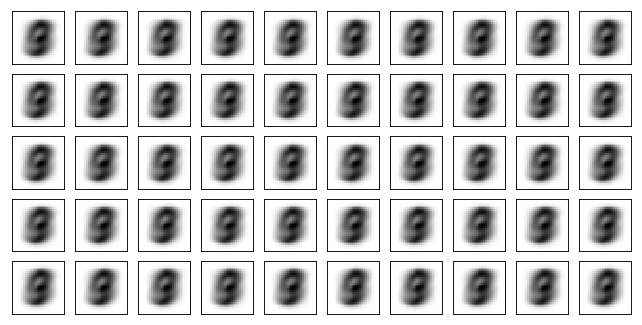

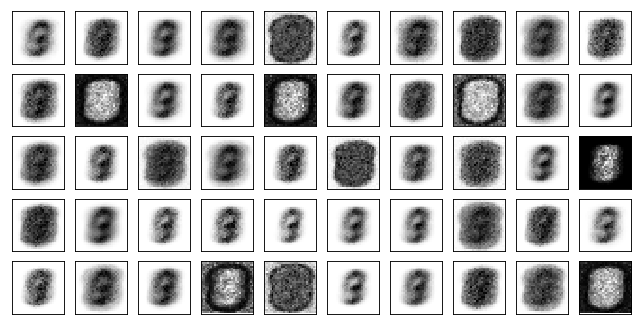

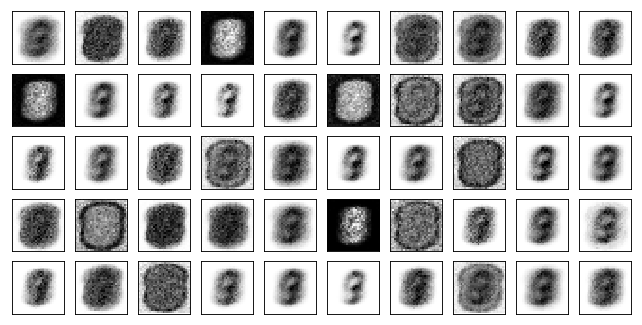

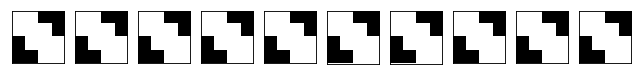

Test losses: 
Adam Discr+bn+dp: 1.34618616 / 7.22006226 / 0.00405802 

Train Epoch: 36 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.6636 D:0.0000
Train Epoch: 36 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.5991 D:0.0018
Train Epoch: 36 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.6624 D:0.0000
Train Epoch: 36 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.6593 D:0.0003
Train Epoch: 36 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.7173 D:0.0000
Train Epoch: 36 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.7677 D:0.0000
Model Adam Discr+bn+dp:


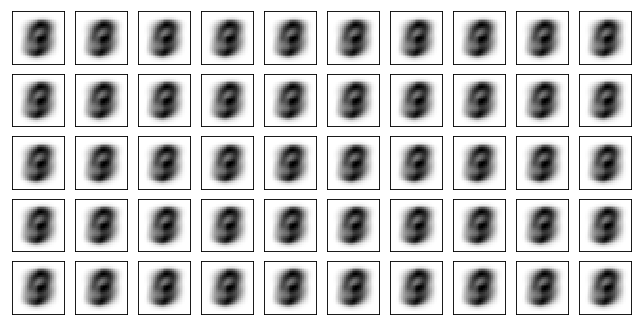

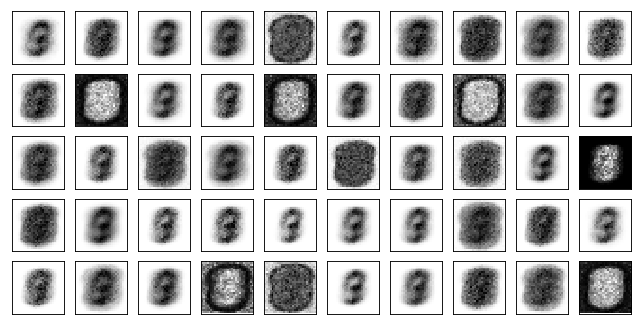

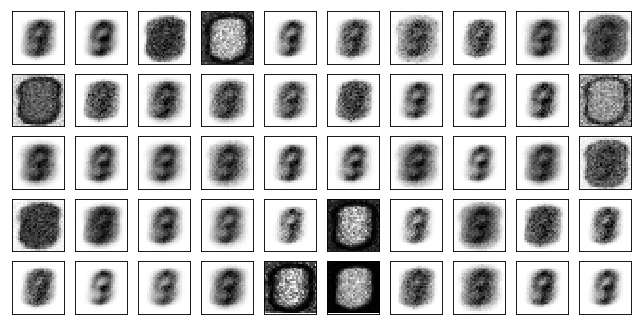

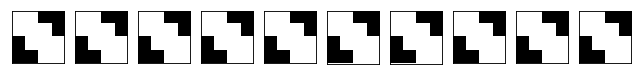

Test losses: 
Adam Discr+bn+dp: 1.34598374 / 7.45223284 / 0.00070378 

Train Epoch: 37 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.7886 D:0.0000
Train Epoch: 37 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.6835 D:0.0000
Train Epoch: 37 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.7328 D:0.0000
Train Epoch: 37 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.6796 D:0.0000
Train Epoch: 37 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.7295 D:0.0000
Train Epoch: 37 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.8501 D:0.0001
Model Adam Discr+bn+dp:


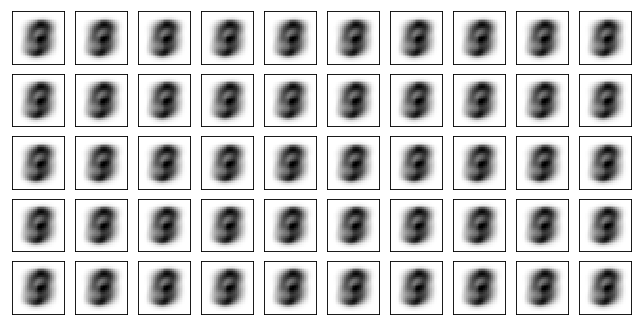

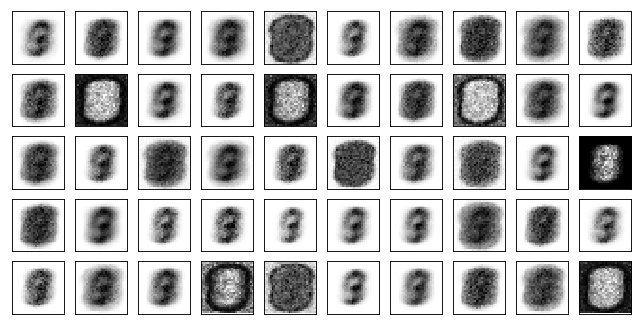

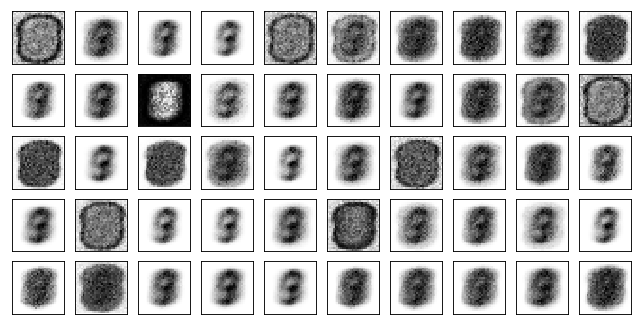

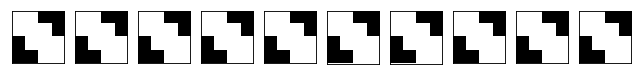

Test losses: 
Adam Discr+bn+dp: 1.34610748 / 7.87433243 / 0.00036234 

Train Epoch: 38 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.8046 D:0.0000
Train Epoch: 38 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.8234 D:0.0000
Train Epoch: 38 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.5929 D:0.0002
Train Epoch: 38 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.6549 D:0.0000
Train Epoch: 38 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.7821 D:0.0000
Train Epoch: 38 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.6842 D:0.0000
Model Adam Discr+bn+dp:


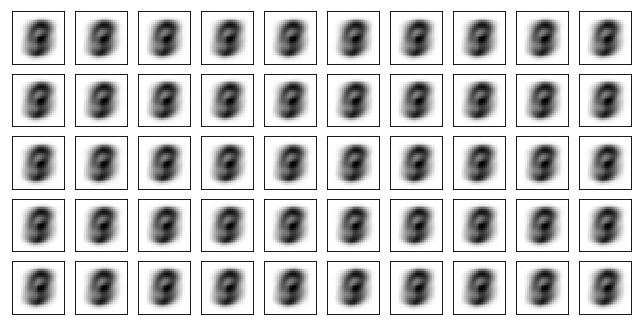

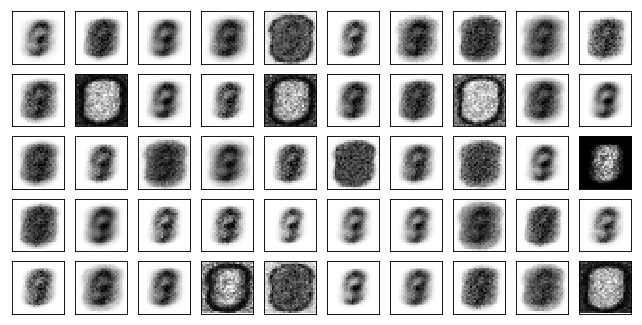

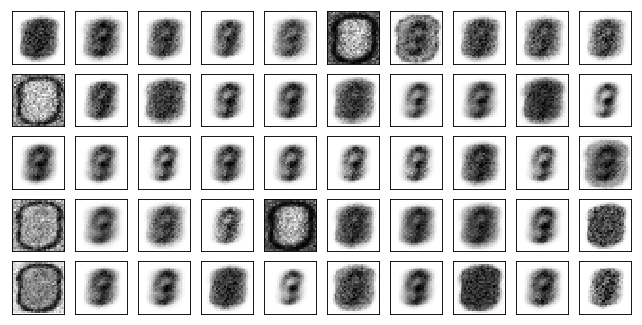

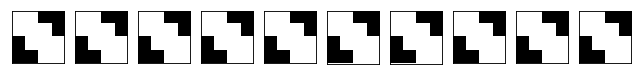

Test losses: 
Adam Discr+bn+dp: 1.34643221 / 7.46623230 / 0.00020238 

Train Epoch: 39 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.6672 D:0.0000
Train Epoch: 39 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.7836 D:0.0000
Train Epoch: 39 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.7958 D:0.0000
Train Epoch: 39 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.7902 D:0.0000
Train Epoch: 39 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.8069 D:0.0000
Train Epoch: 39 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.7924 D:0.0000
Model Adam Discr+bn+dp:


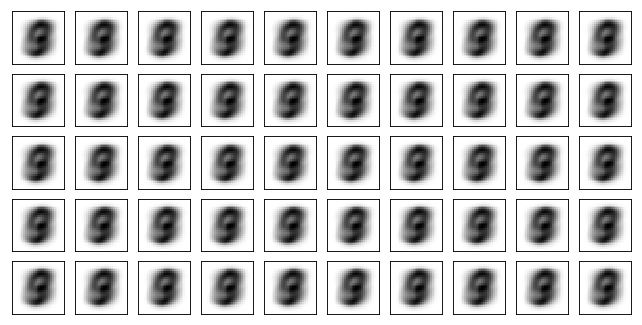

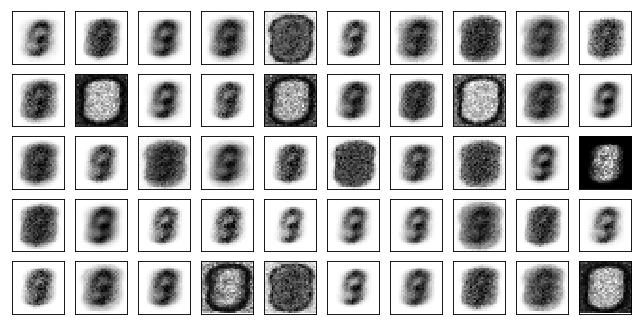

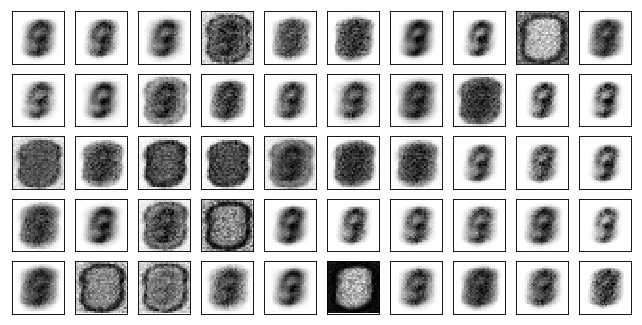

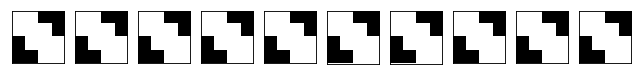

Test losses: 
Adam Discr+bn+dp: 1.34652114 / 7.70145464 / 0.00000764 

Train Epoch: 40 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.7203 D:0.0000
Train Epoch: 40 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.7144 D:0.0000
Train Epoch: 40 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.8821 D:0.0001
Train Epoch: 40 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.8549 D:0.0000
Train Epoch: 40 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.8211 D:0.0000
Train Epoch: 40 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.8067 D:0.0000
Model Adam Discr+bn+dp:


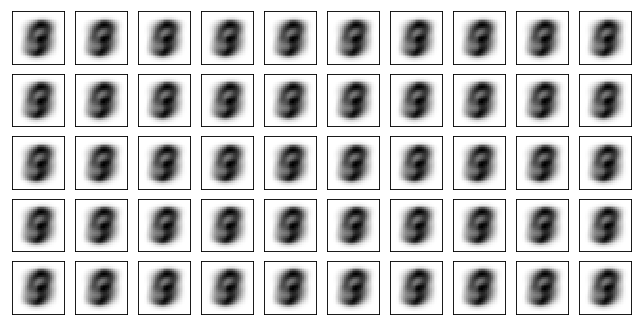

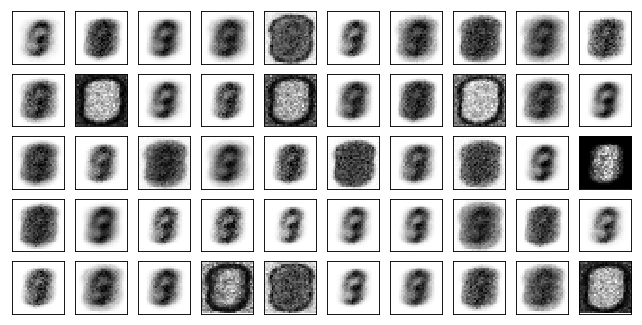

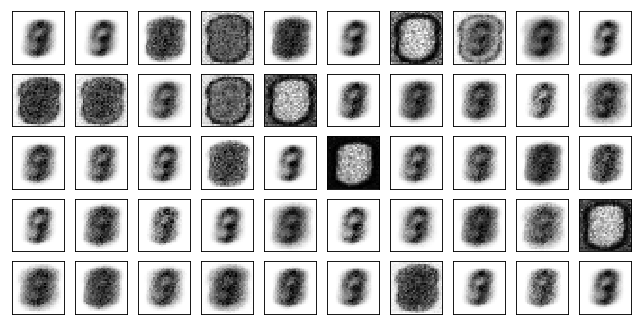

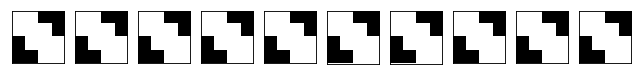

Test losses: 
Adam Discr+bn+dp: 1.34626651 / 7.85884714 / 0.00000124 

Train Epoch: 41 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.8521 D:0.0000
Train Epoch: 41 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.8742 D:0.0000
Train Epoch: 41 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.9073 D:0.0000
Train Epoch: 41 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.6339 D:0.0000
Train Epoch: 41 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.7804 D:0.0000
Train Epoch: 41 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.8055 D:0.0000
Model Adam Discr+bn+dp:


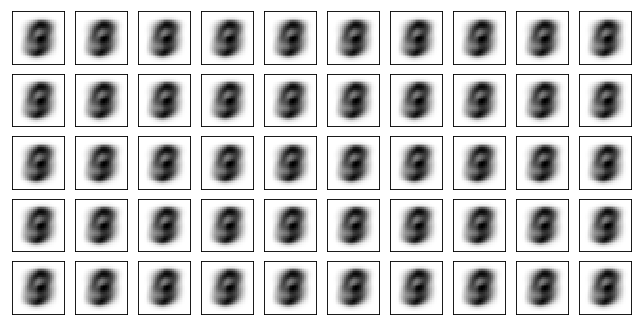

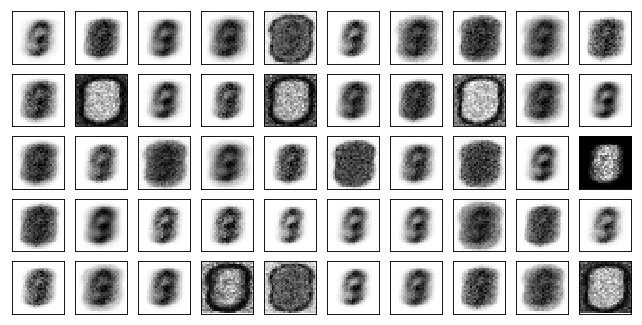

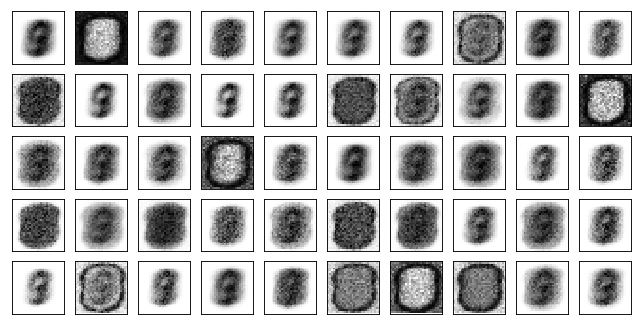

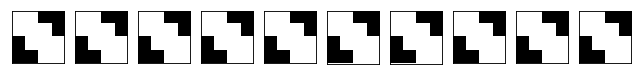

Test losses: 
Adam Discr+bn+dp: 1.34615314 / 8.13461876 / 0.00004723 

Train Epoch: 42 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:2.0267 D:0.0000
Train Epoch: 42 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.8413 D:0.0000
Train Epoch: 42 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.8026 D:0.0000
Train Epoch: 42 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.9540 D:0.0000
Train Epoch: 42 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.8828 D:0.0000
Train Epoch: 42 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.9225 D:0.0000
Model Adam Discr+bn+dp:


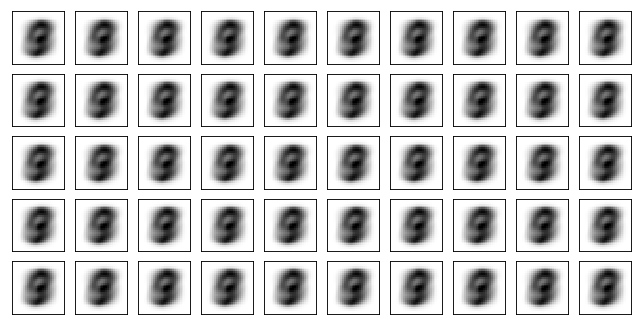

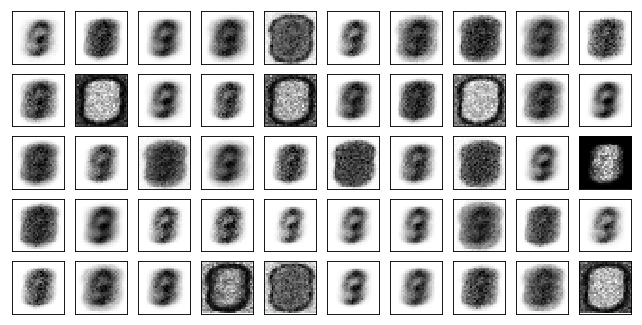

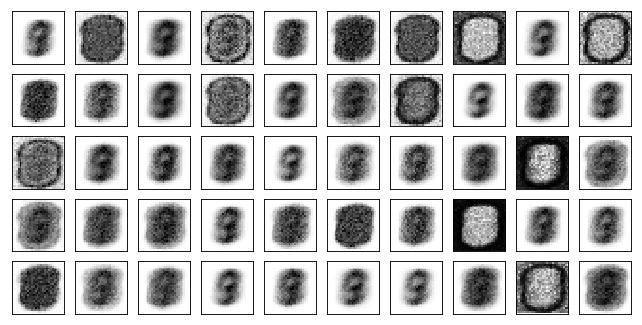

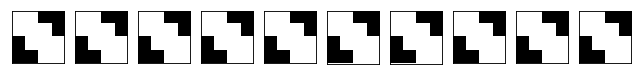

Test losses: 
Adam Discr+bn+dp: 1.34613848 / 8.47824383 / 0.00000067 

Train Epoch: 43 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.9670 D:0.0000
Train Epoch: 43 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.9253 D:0.0000
Train Epoch: 43 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.8065 D:0.0000
Train Epoch: 43 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.8665 D:0.0000
Train Epoch: 43 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.8724 D:0.0000
Train Epoch: 43 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.6543 D:0.0000
Model Adam Discr+bn+dp:


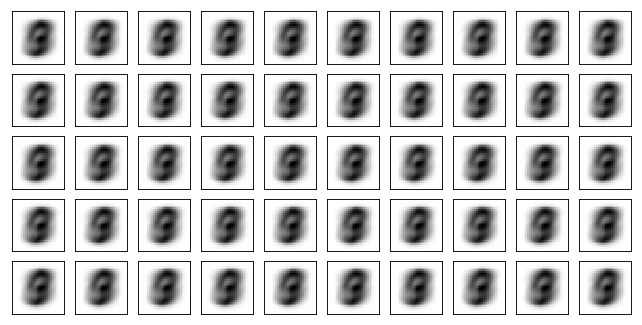

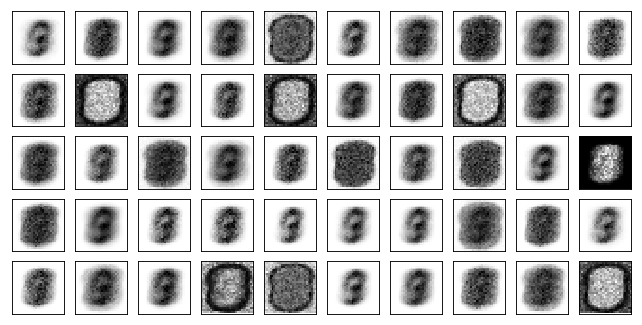

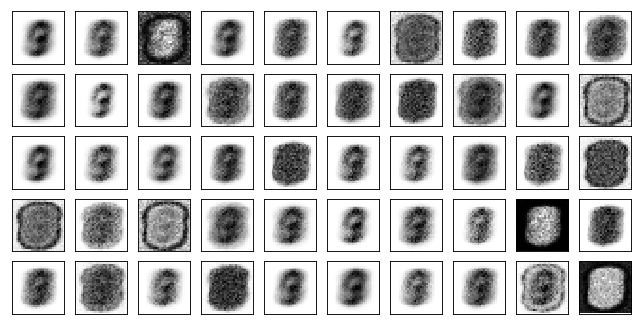

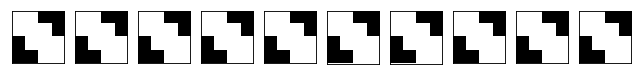

Test losses: 
Adam Discr+bn+dp: 1.34603763 / 7.08806515 / 0.00000179 

Train Epoch: 44 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.5499 D:0.0000
Train Epoch: 44 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.8798 D:0.0000
Train Epoch: 44 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.8916 D:0.0000
Train Epoch: 44 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.9001 D:0.0000
Train Epoch: 44 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.9174 D:0.0000
Train Epoch: 44 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.9462 D:0.0000
Model Adam Discr+bn+dp:


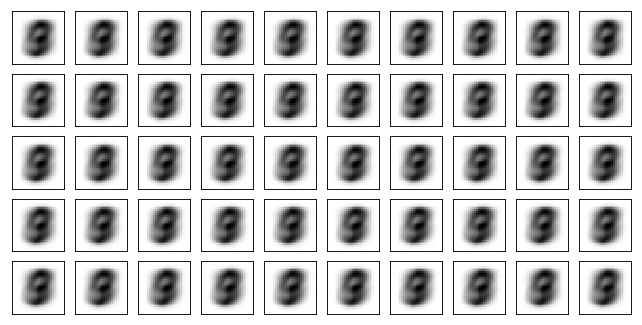

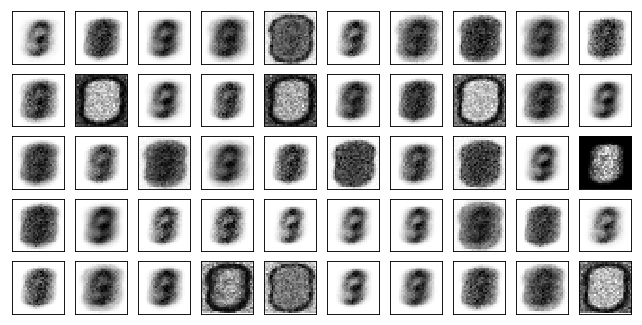

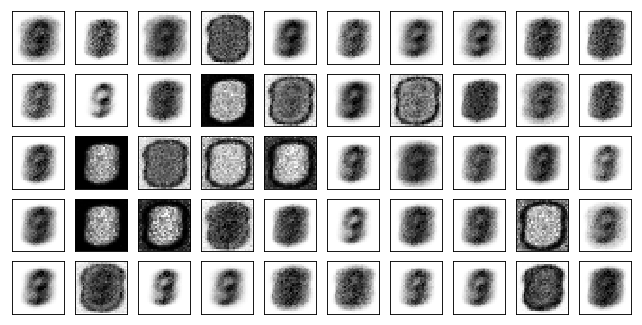

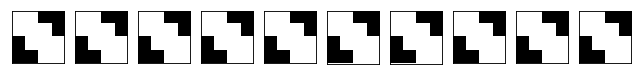

Test losses: 
Adam Discr+bn+dp: 1.34603918 / 8.66878700 / 0.00000011 

Train Epoch: 45 [0/50000 (0%)]	Losses Adam Discr+bn+dp: AE:1.9308 D:0.0000
Train Epoch: 45 [10000/50000 (20%)]	Losses Adam Discr+bn+dp: AE:1.9301 D:0.0000
Train Epoch: 45 [20000/50000 (40%)]	Losses Adam Discr+bn+dp: AE:1.9903 D:0.0000
Train Epoch: 45 [30000/50000 (60%)]	Losses Adam Discr+bn+dp: AE:1.7499 D:0.0000
Train Epoch: 45 [40000/50000 (80%)]	Losses Adam Discr+bn+dp: AE:1.8852 D:0.0000
Train Epoch: 45 [50000/50000 (100%)]	Losses Adam Discr+bn+dp: AE:1.8848 D:0.0000


KeyboardInterrupt: 

In [15]:
for epoch in range(1, 71):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

In [ ]:
torch.save(models['Adam Discr+bn+dp'], './adam_fc_nooh')

### Вывод результатов

In [ ]:
model = torch.load('./adam_fc_nooh')

In [ ]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(-1, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    enc_to_lot = encoded.view(-1, 1, 4, 4).clamp(-1, 1).data.numpy()
    print ('enc=', encoded.shape)


In [ ]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_latent(enc_to_lot, (5, 10))

In [ ]:
def show_generated_samples():
    pred_z = torch.randn((50, 16))
       
    pred_gen = model.decode(pred_z)
    generated = pred_gen.view(-1, 1, 28, 28).data.numpy()  
    plot_mnist(generated, (5, 10))

In [ ]:
show_generated_samples()